In [12]:
module('load','cuda/11.2')
module('load','nibabel/2.5.0')
module('load','pytorch/gpu-cuda-11.2/1.8.1')

In [13]:
import nibabel as nb
import numpy as np
import torch

import os
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader

import glob
import re

from data.ESRGAN_3d_dataset import *
#from model.ESRGAN_3d_model_Copy import * # for WGAN-GP
#from model.model_VGG16_IN import * # for ESRGAN_VGG16_IN
#from model.model_pretrain_resnet import *

from model.toy_model_3d import * # for c11
#rom model.model_VGG19_LN import *   #for ESRGAN_19
from utils.utils import *

In [97]:
import sys
sys.path.append("/u/wangqi/git_wq/ArSSR")
import model_arssr as md

In [22]:
ckp = torch.load("../saved_models/Jupyter_C14_Crop_38_999.pth")
#ckp = torch.load("../saved_models/c15_Crop_64_999.pth")
#ckp = torch.load("../saved_models/pre-trained_c15_Crop_38_999.pth")

In [23]:
model_name = ckp['Gnet_state_dict']
#model_name = "Jupyter_C14_Crop_generator_20_999"
#model_name = "c15_Crop_generator_38_999"
#model_name = "c11_generator_102_1359"

In [5]:
#datapath = "/ptmp/wangqi/transfer_folder/LS200X_Norm/crops/"
datapath="/ptmp/wangqi/MPI_subj3/crops"

In [6]:
data = DataLoader(CropDataset(datapath),batch_size = 4,drop_last=True,num_workers=8,shuffle=True)

In [7]:
i,img = next(enumerate(data))

In [8]:
lr_arr = img['lr']
hr_arr = img['hr']

In [24]:
model = Generator()
model.eval()
model.to("cuda:0")
model.load_state_dict(model_name)
#model.load_state_dict(torch.load(f'../saved_models/{model_name}.pth'),strict = False)

<All keys matched successfully>

In [98]:
encoder_name = 'RDN'
decoder_depth = 8
decoder_width = 256
feature_dim = 128
#pre_trained_model = '/ptmp/wangqi/ArSSR_model/model_param_2000.pt'
DEVICE="cuda:0"
pre_trained_model = '/u/wangqi/git_wq/ArSSR/pre_trained_models/ArSSR_RDN.pkl'
gpu = 0
is_gpu = 1
#input_path = '/ptmp/wangqi/fb9365/crops'
input_path='/ptmp/wangqi/transfer_folder/crops'
output_path = '/ptmp/wangqi/fb9365/fake_ArSSR'
scale = 2.0
ArSSR = md.ArSSR(encoder_name=encoder_name,
                    feature_dim=feature_dim,
                    decoder_depth=int(decoder_depth / 2),
                    decoder_width=decoder_width).to(DEVICE)
ArSSR.load_state_dict(torch.load(pre_trained_model, map_location=DEVICE))


<All keys matched successfully>

In [99]:
def generate(img_lr_tmp,xyz_hr_tmp):
    ArSSR.eval()
    with torch.no_grad():
        lr_size = img_lr_tmp.shape[1]
        y = np.zeros(((lr_size*2)**3,1)) # target output: (hr_size ** 3)
        img_lr_tmp = img_lr_tmp.unsqueeze(1).float().to(DEVICE)
        xyz_hr_tmp = xyz_hr_tmp.view(1,-1,3).float()
        for j in tqdm(range(lr_size*2)):
            xyz_hr_patch = xyz_hr_tmp[:, j * lr_size*2 *lr_size*2:
                                     j * lr_size*2 * lr_size*2 + lr_size*2 * lr_size*2, :].to(DEVICE)
            img_pre_path = ArSSR(img_lr_tmp, xyz_hr_patch)
            y[j * lr_size*2 * lr_size*2:
                    j * lr_size*2 * lr_size*2 + lr_size*2 * lr_size*2] = \
                img_pre_path.cpu().detach().numpy().reshape(lr_size*2 * lr_size*2, 1)
        y = y.reshape((lr_size*2, lr_size*2, lr_size*2))
    return y

In [100]:
def make_coord(shape, ranges=None, flatten=True):
    """
    Make coordinates at grid centers.
    """
    coord_seqs = []
    for i, n in enumerate(shape):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n).float()
        coord_seqs.append(seq)
    ret = torch.stack(torch.meshgrid(*coord_seqs), dim=-1)
    if flatten:
        ret = ret.view(-1, ret.shape[-1])
    return ret

In [101]:
xyz_lr_coor = make_coord(hr_arr[2].squeeze().shape,flatten=True)
sr_arssr = generate(lr_arr[2],xyz_lr_coor)

100%|██████████| 64/64 [00:06<00:00,  9.17it/s]


(-0.5, 63.5, 63.5, -0.5)

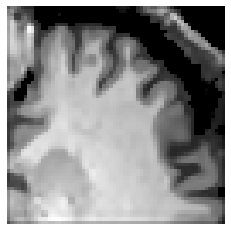

In [26]:
import matplotlib.pyplot as plt
plt.imshow(sr_arssr[16],cmap='gray')
plt.axis("off")

In [25]:
sr_wg = model(lr_arr.to("cuda:0"))

(-0.5, 63.5, 63.5, -0.5)

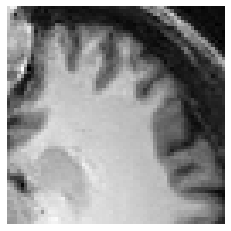

In [28]:
plt.imshow(sr_wg[0,0,16].detach().squeeze().cpu().numpy(),cmap='gray')
plt.axis("off")

In [10]:
sr = model(lr_arr.to("cuda:0"))

In [13]:
def plot_val(sr,hr,title):
    fig,ax = plt.subplots(2,4,figsize=(20,10))
    axe = ax.ravel()
    fig.suptitle(title)
    with torch.no_grad():
        psnr_v = psnr(sr.squeeze().cpu().numpy(),hr.squeeze().numpy())
        ssim_v = ssim(sr.squeeze().cpu().numpy(),hr.squeeze().numpy())
    axe[0].text(5,5,f"psnr{psnr_v:.3f}",fontdict={'color':'red','size':16,'weight':'bold'})
    axe[0].text(5,9,f"SSIM{ssim_v:.3f}",fontdict={'color':'red','size':16,'weight':'bold'})
    for i in range(hr.size()[0]):
        axe[i].imshow(hr[i,0,32].squeeze().detach().numpy(),cmap='gray')
        axe[i+4].imshow(sr[i,0,32].squeeze().detach().cpu().numpy(),cmap='gray')
        
        

In [113]:
def move_img_np(img):
    if isinstance(img,torch.Tensor):
        img = img.detach().cpu().numpy()
    while(img.ndim > 3):
        img = img.squeeze()
    return img

# plot line profile and image
def plot_lines(*args):
    '''
    input:
    -----
        list : GT,ArSSR,WGAN_GP,ESRGAN
    '''
    img_list = [move_img_np(im) for im in args]
    line_len = 64
    x_idx = 20
    y_coor = 20
    z_s_coor = 0
    
    # assign lines from images
    gt_img,linear_sr,arssr_img,wgan_img,esrgan_img = img_list
    GT_line_prof = gt_img[x_idx,y_coor,z_s_coor:z_s_coor+line_len].ravel()      # GT HR
    linear_line_prof = linear_sr[x_idx,y_coor,z_s_coor:z_s_coor+line_len].ravel() # Linear SR
    wgan_line_prof = wgan_img[x_idx,y_coor,z_s_coor:z_s_coor+line_len].ravel() # Linear SR
    ArSSR_line_prof = arssr_img[x_idx,y_coor,z_s_coor:z_s_coor+line_len].ravel()          # ArSSR SR
    ESRGAN_line_prof = esrgan_img[x_idx,y_coor,z_s_coor:z_s_coor+line_len].ravel()  # ESRGAN SR
    
    x = np.arange(0,line_len,1)
    
    fig,axes = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'width_ratios':[2,1]})
    ax1,ax2 = axes.ravel()
    ax1.plot(x,GT_line_prof,'k',
             x,linear_line_prof,'mx:',
             x,ArSSR_line_prof,'b:',
             x,wgan_line_prof,'r-*',
             x,ESRGAN_line_prof,'g--')
    ax1.grid("on")
    ax1.set_xlabel("line depth")
    ax1.set_ylabel("intensity")
    ax1.legend(("GT","Linear interp","Implicit Neural Rep","WGAN-GP","WGAN-GP_FE"))
    ax2.imshow(gt_img[x_idx],cmap='gray')
    ax2.plot([y_coor,y_coor],[z_s_coor,z_s_coor+line_len],'r')
    
    ax2.axis('off')
    fig.show()

In [104]:
linear_hr = torch.nn.functional.interpolate(lr_arr,scale_factor=2)

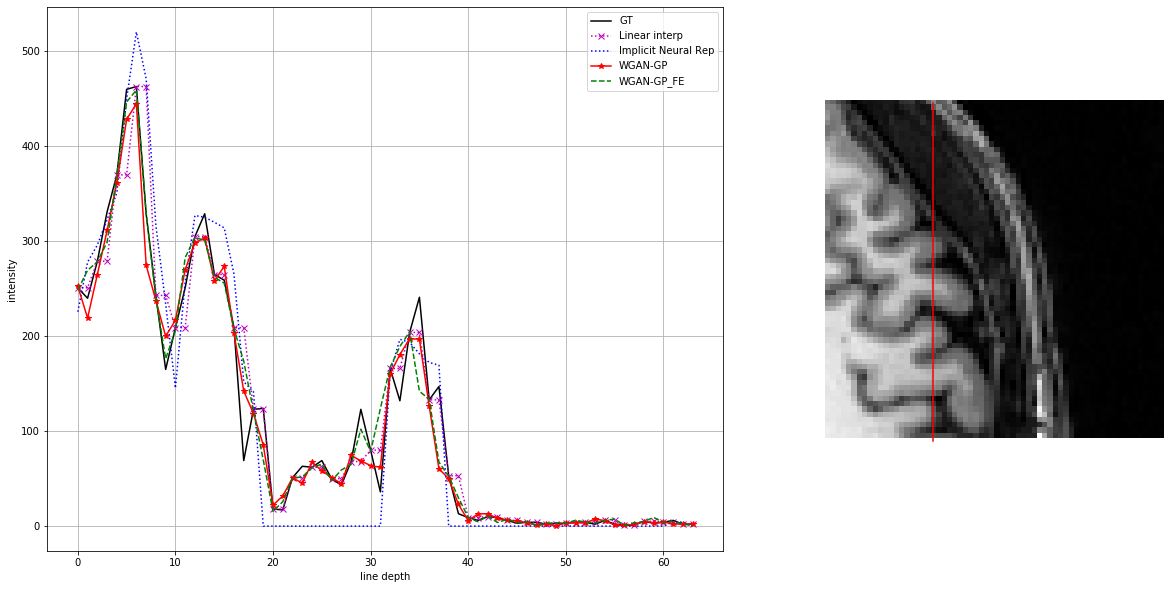

In [114]:
plot_lines(hr_arr[2],linear_hr[2],sr_arssr,sr_wg[2],sr_er[2])

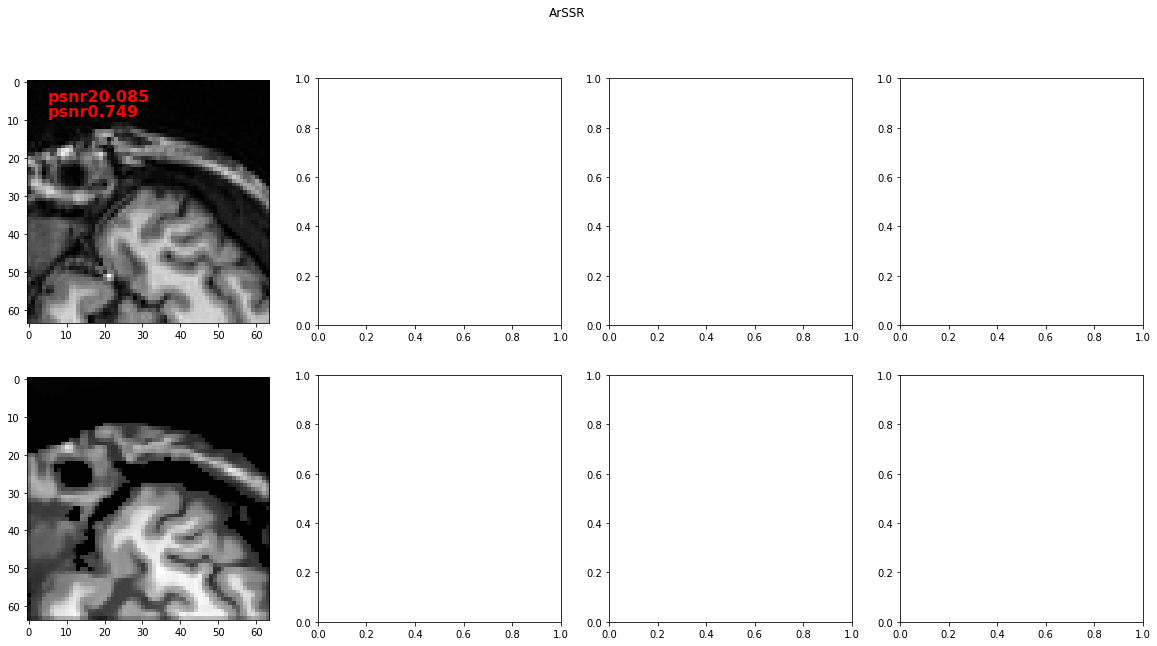

In [62]:
plot_val(torch.tensor(sr_arssr).unsqueeze(0).unsqueeze(0),hr_arr[0].unsqueeze(0),"ArSSR")

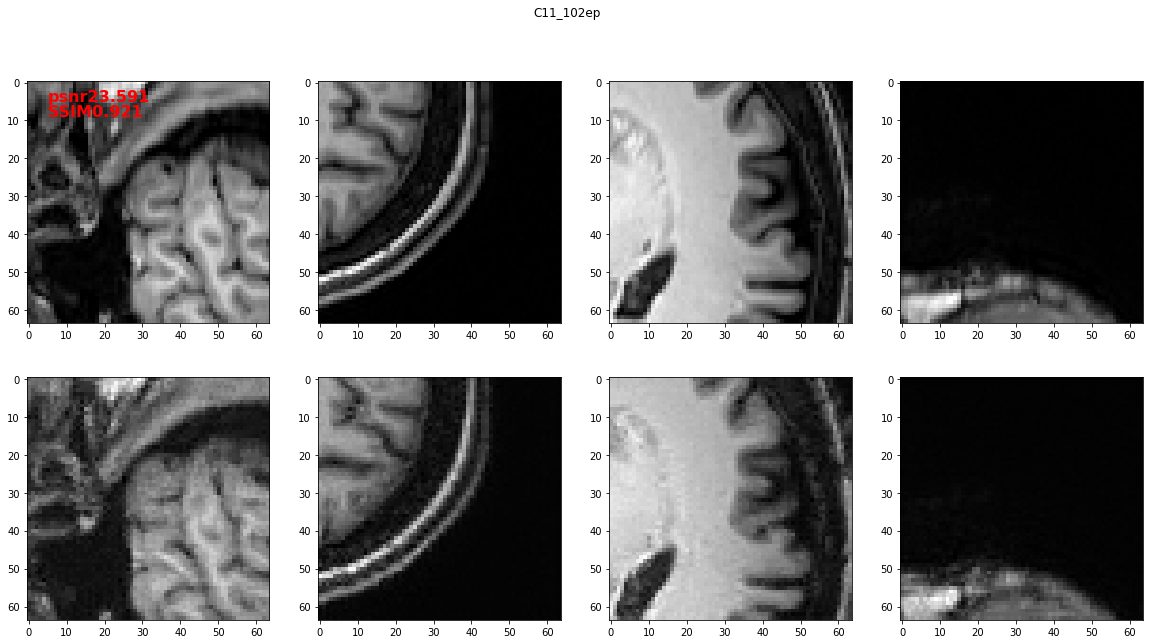

In [23]:
plot_val(sr_er,hr_arr,"C11_102ep")

In [29]:
linear_hr = torch.nn.functional.interpolate(lr_arr,scale_factor=2)

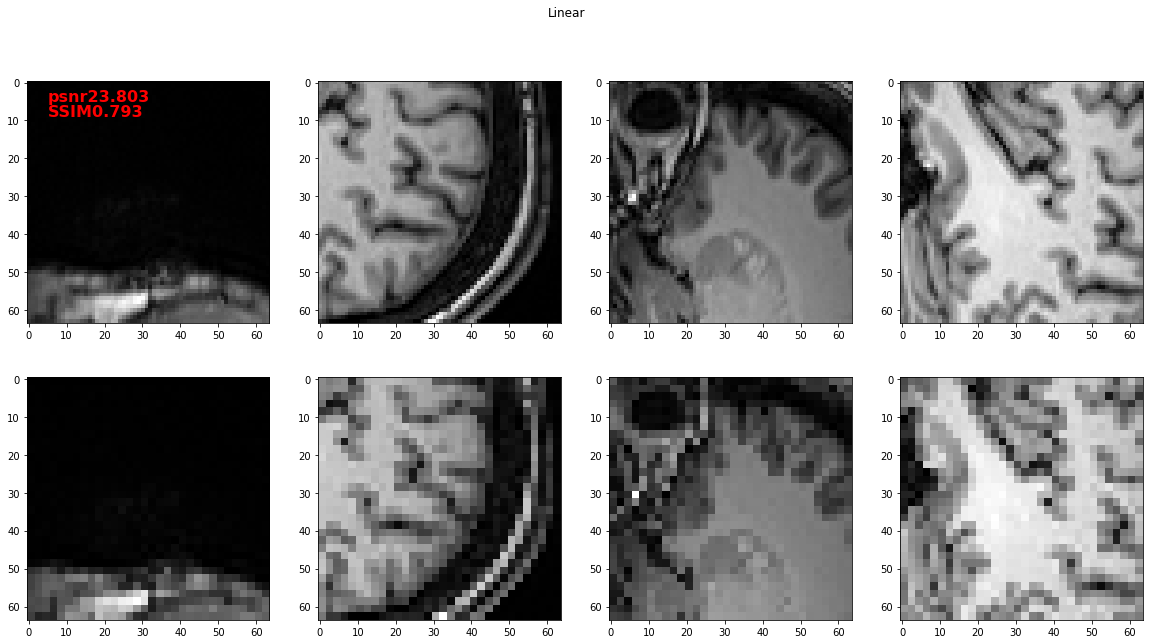

In [30]:
plot_val(linear_hr,hr_arr,"Linear")

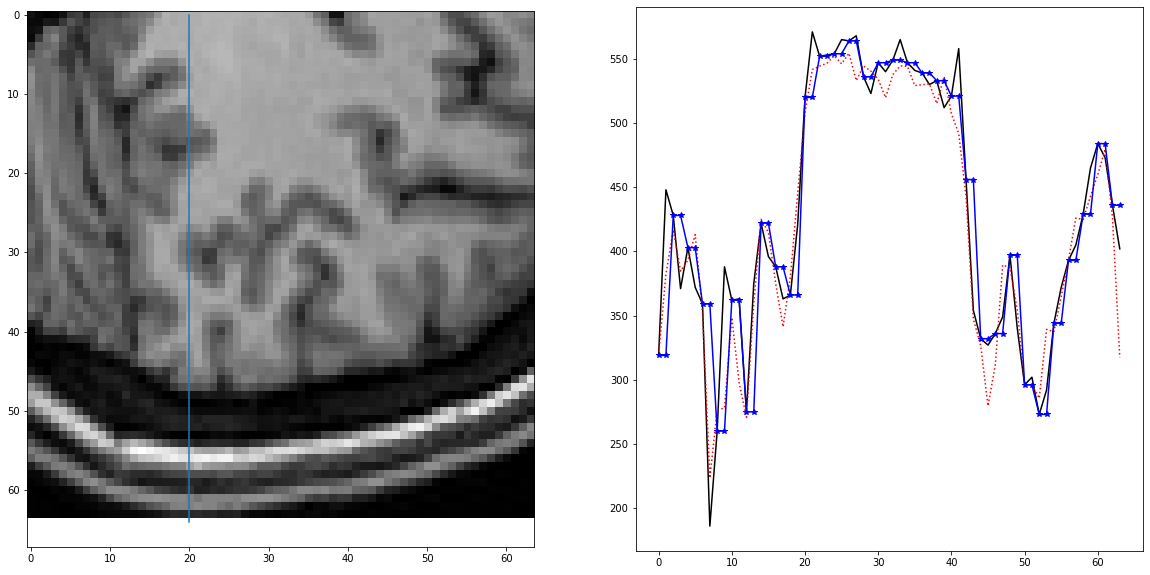

In [42]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(hr_arr[0,0,32],cmap='gray')
ax1.plot([20,20],[0,64])
ax2 = fig.add_subplot(122)
ax2.plot(hr_arr[0,0,32,20,:].ravel(),'k-',sr_wg[0,0,32,20,:].detach().cpu().ravel(),'r:',linear_hr[0,0,32,20,:].cpu().ravel(),'b-*')

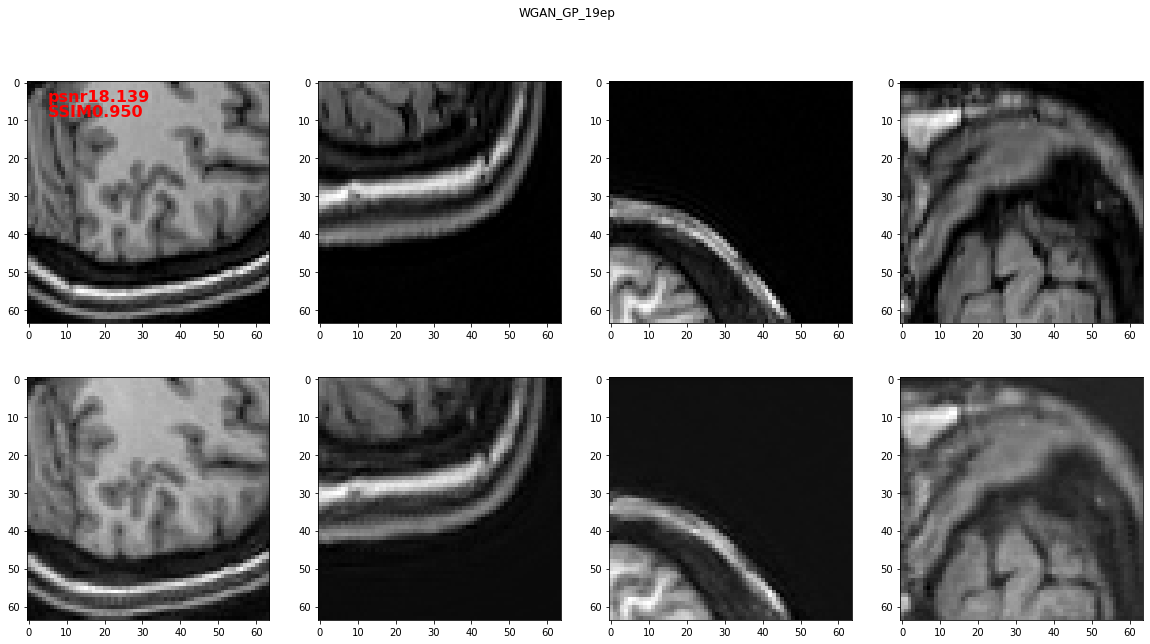

In [19]:
plot_val(sr_wg,hr_arr,"WGAN_GP_19ep")

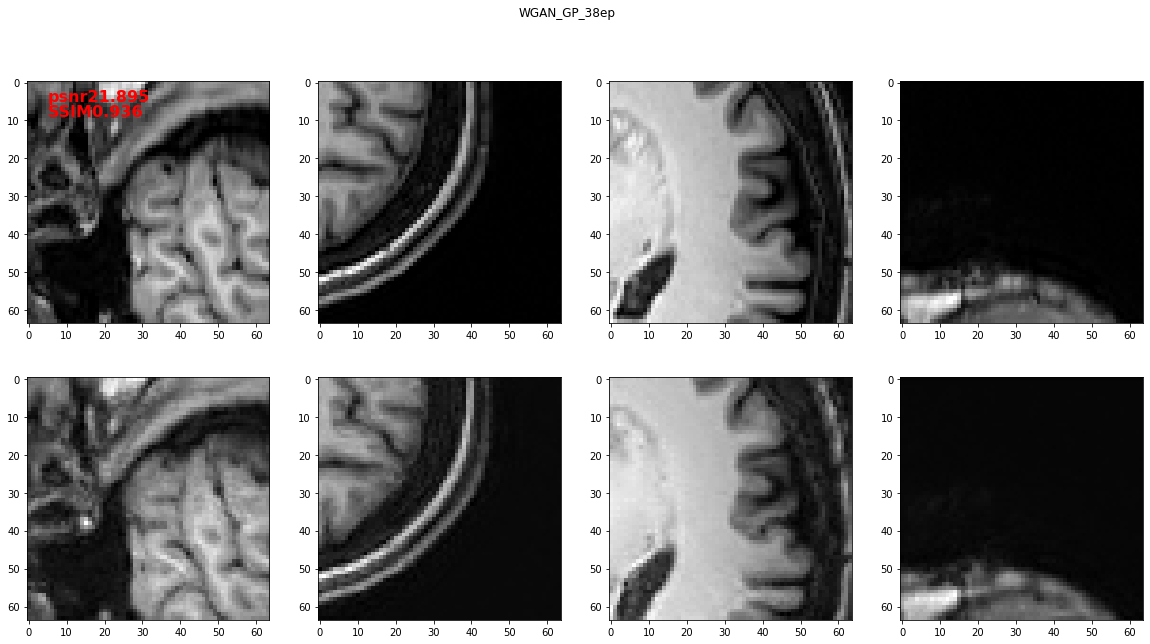

In [18]:
plot_val(sr_wg,hr_arr,"WGAN_GP_38ep")

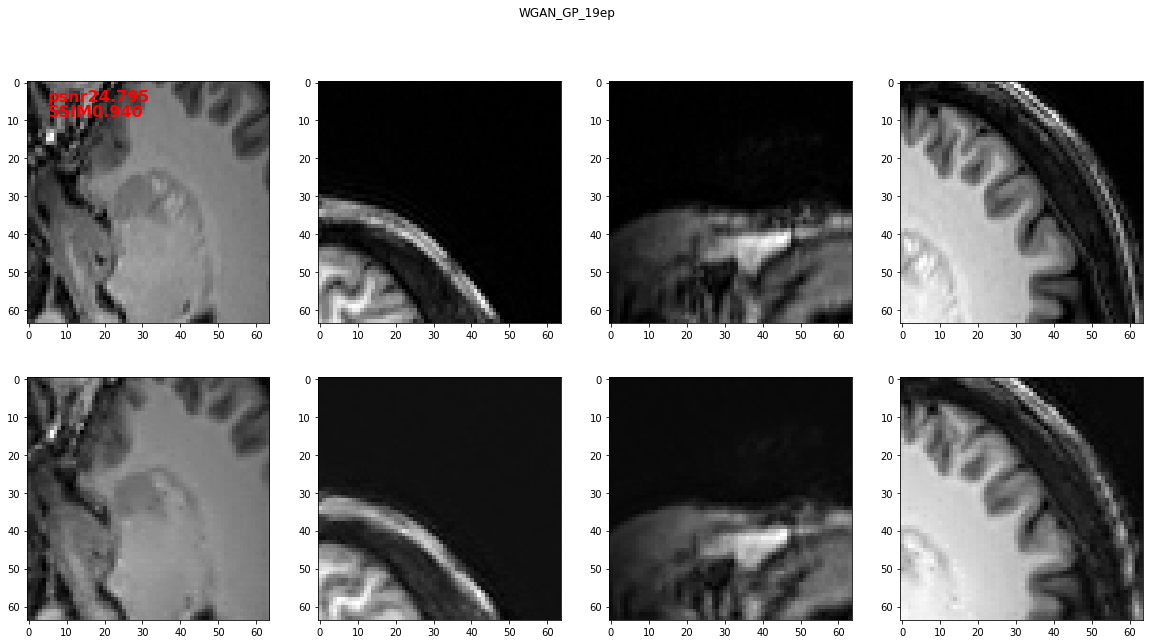

In [46]:
plot_val(sr_wg,hr_arr,"WGAN_GP_19ep")

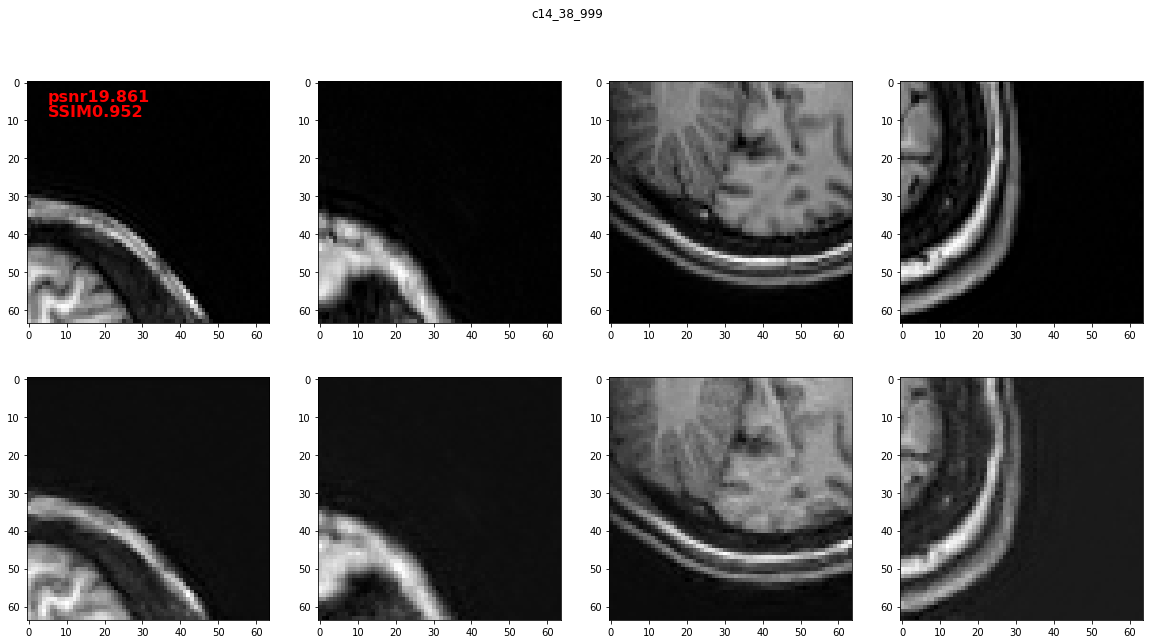

In [44]:
plot_val(sr_wg,hr_arr,"c14_38_999")

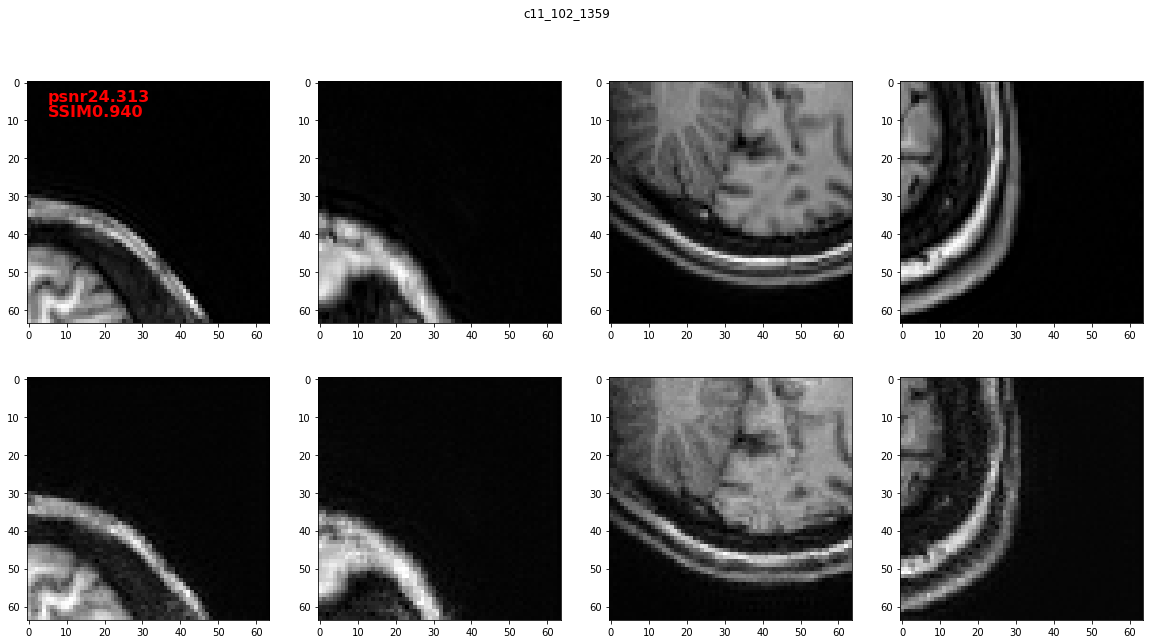

In [49]:
plot_val(sr_err,hr_arr,"c11_102_1359")

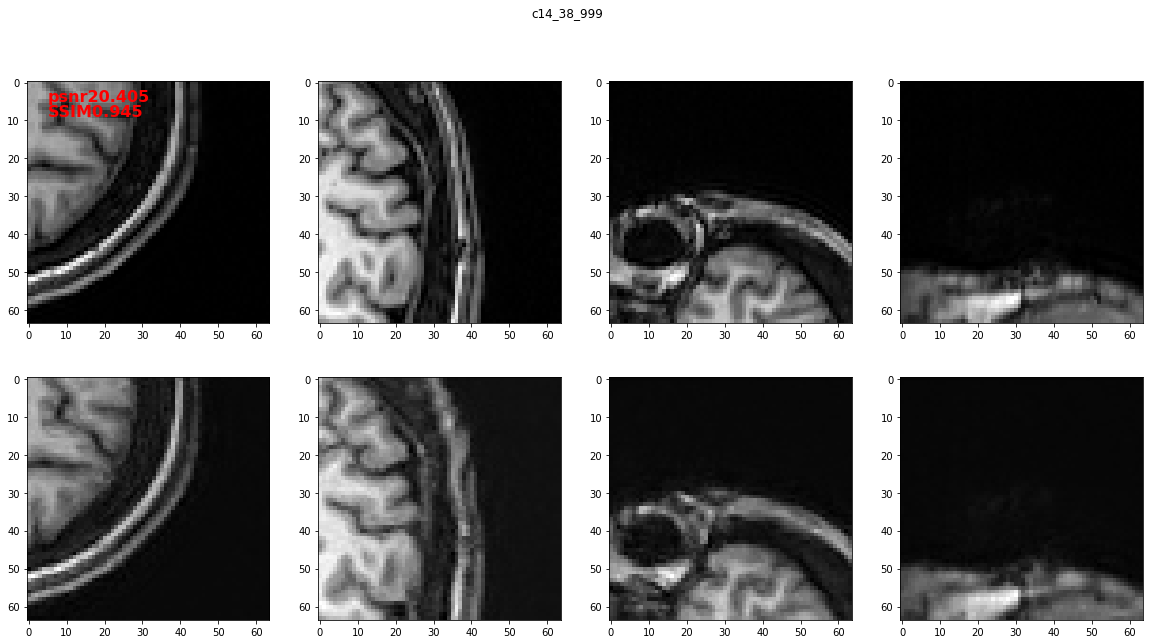

In [26]:
plot_val(sr_wg,hr_arr,"c14_38_999")

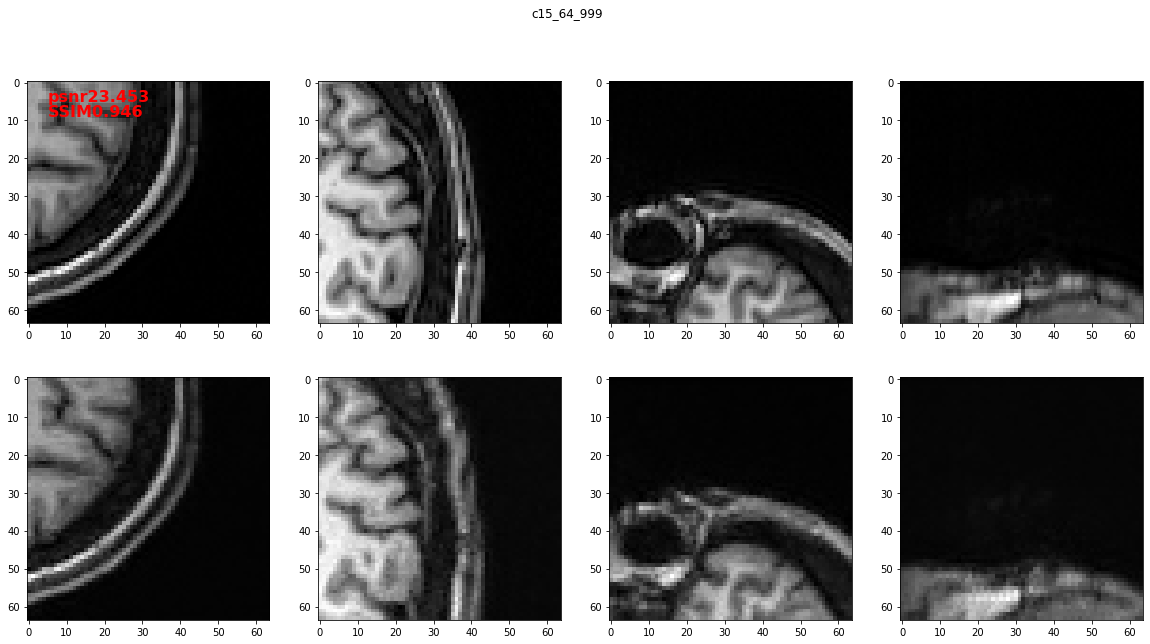

In [14]:
plot_val(sr_er,hr_arr,"c15_64_999")

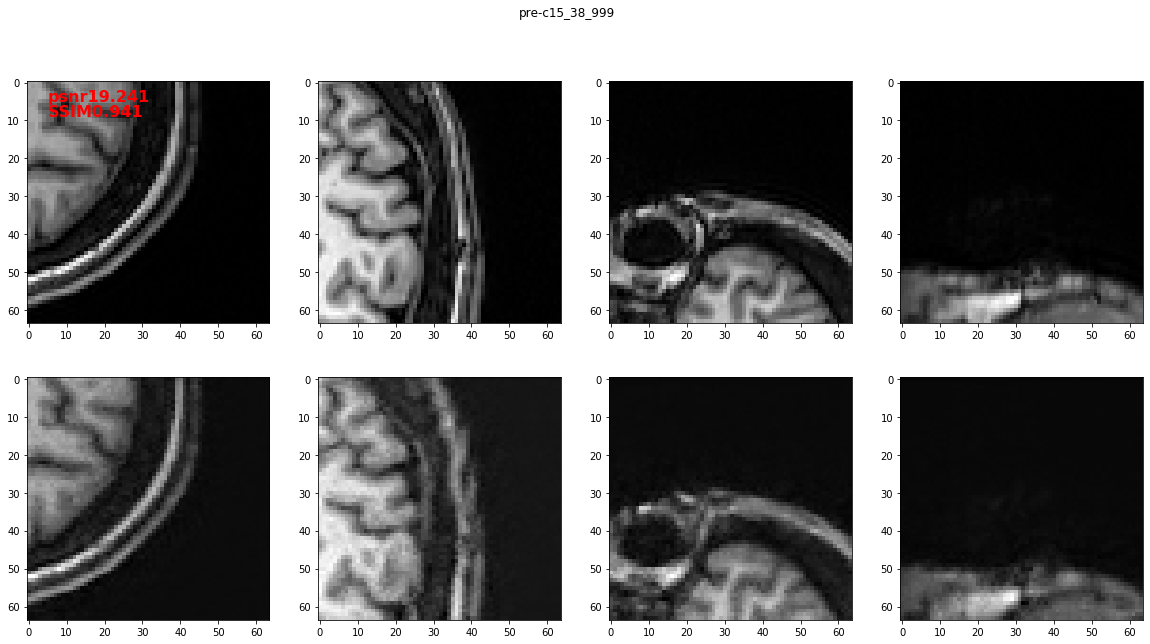

In [20]:
plot_val(sr_err,hr_arr,"pre-c15_38_999")

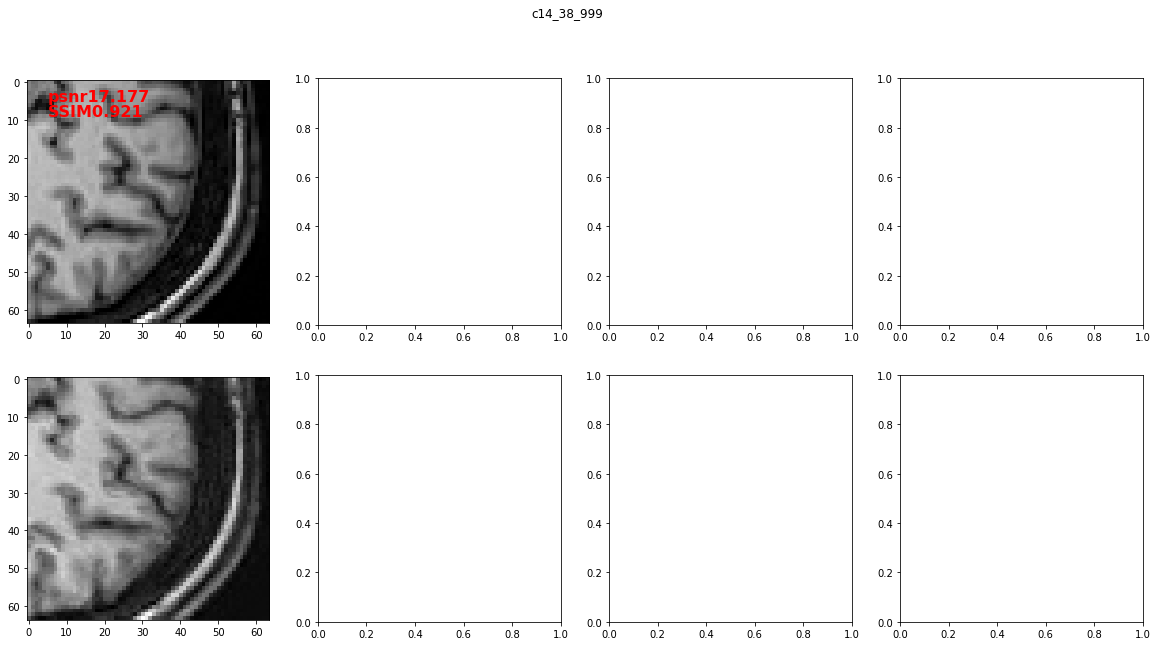

In [31]:
plot_val(sr_wg[1].unsqueeze(0),hr_arr[1].unsqueeze(0),"c14_38_999")

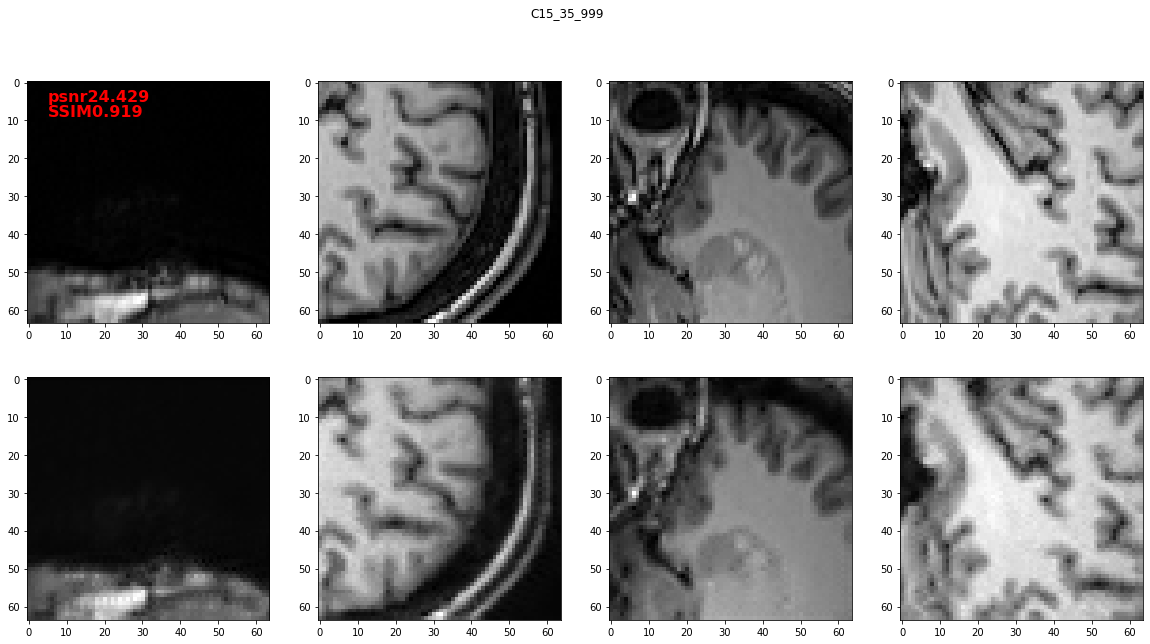

In [12]:
plot_val(sr_er[0],hr_arr,"C15_35_999")

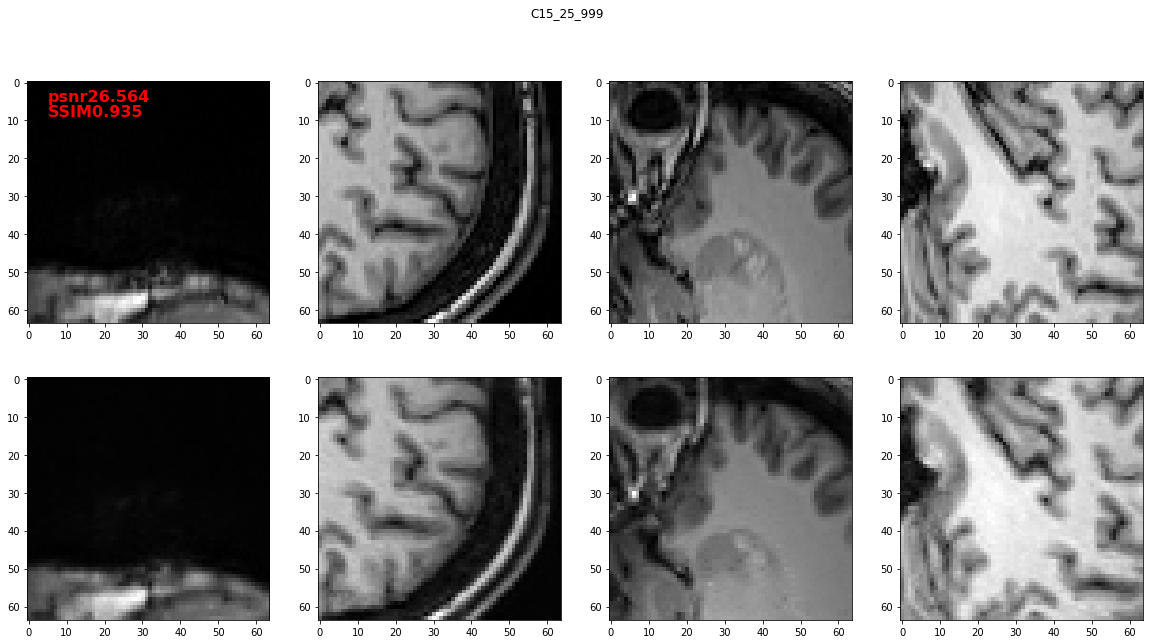

In [22]:
plot_val(sr_er,hr_arr,"C15_25_999")

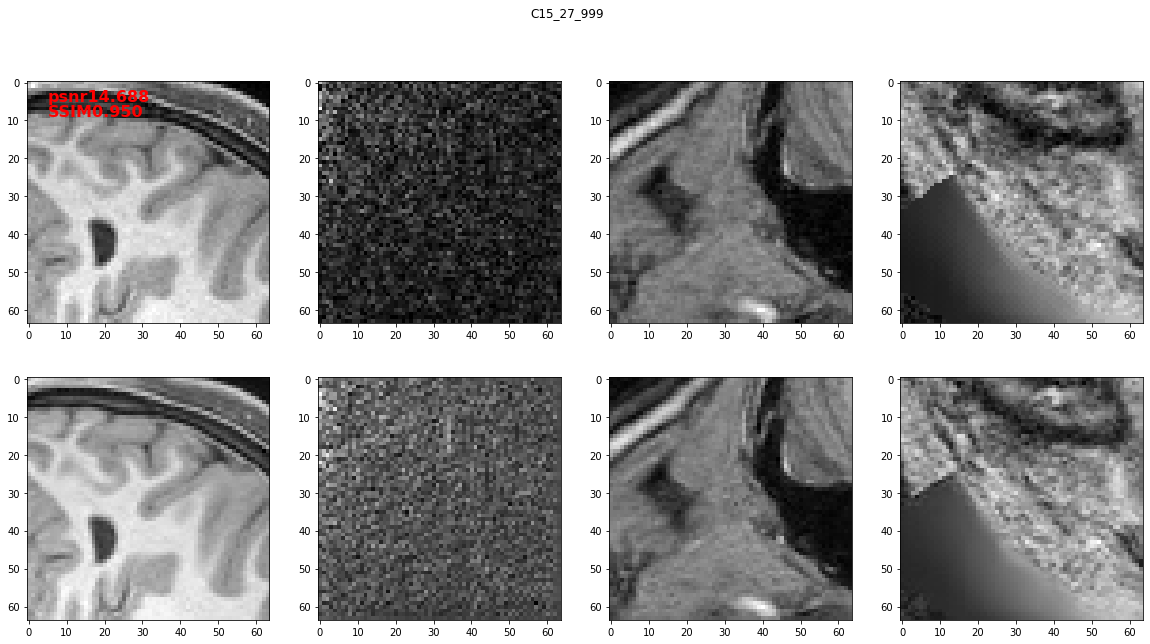

In [40]:
plot_val(sr_er,hr_arr,"C15_27_999")

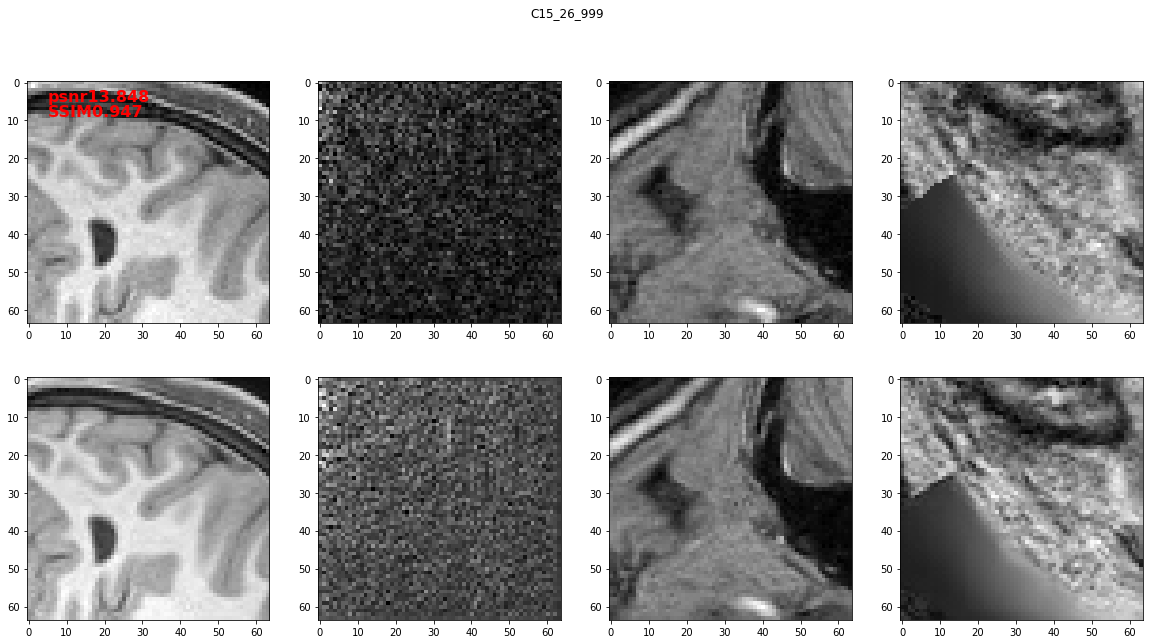

In [30]:
plot_val(sr_er,hr_arr,"C15_26_999")

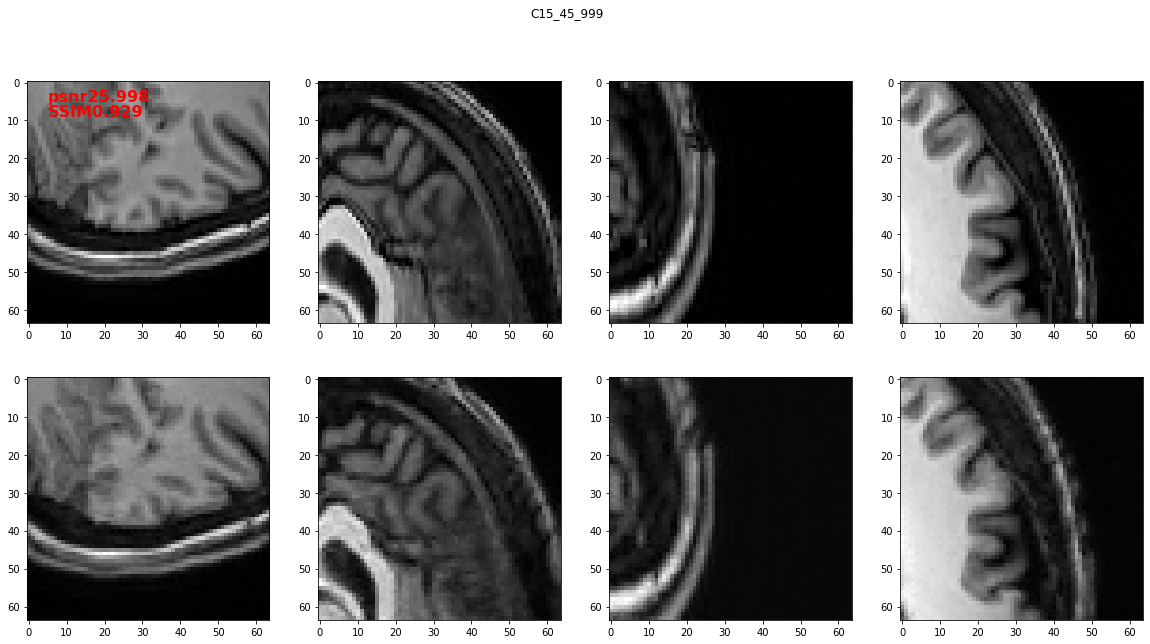

In [26]:
plot_val(sr_er,hr_arr,"C15_45_999")

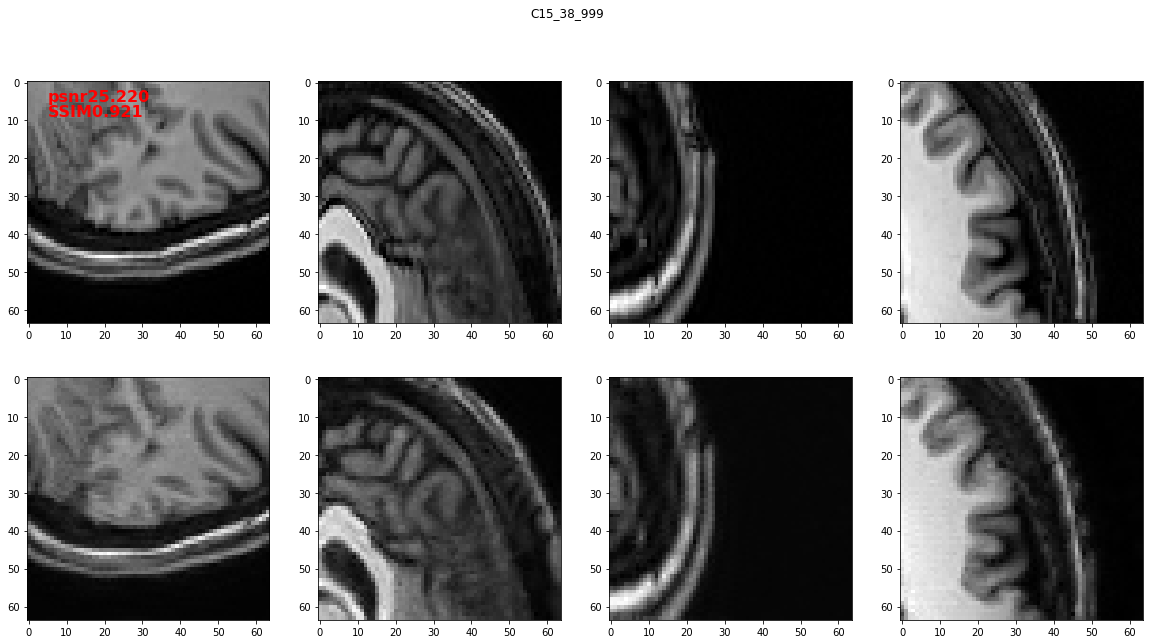

In [21]:
plot_val(sr_er,hr_arr,"C15_38_999")

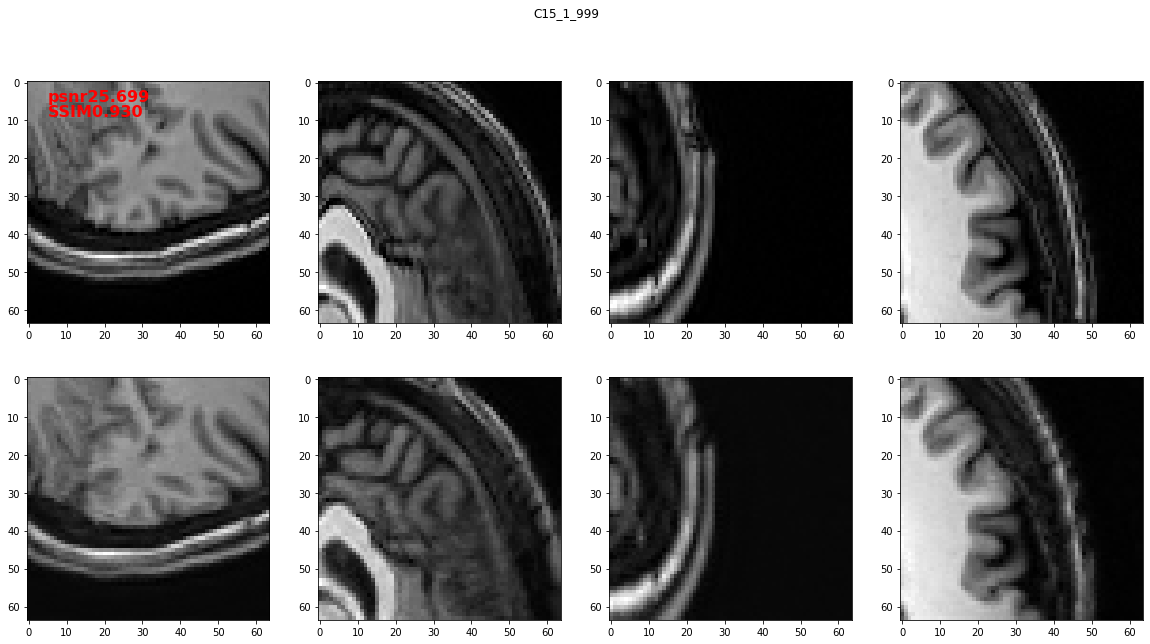

In [16]:
plot_val(sr_er,hr_arr,"C15_1_999")

In [14]:
plot_val(sr[0].unsqueeze(0),hr_arr[0].unsqueeze(0),"C11_102_1359")

NameError: name 'sr' is not defined

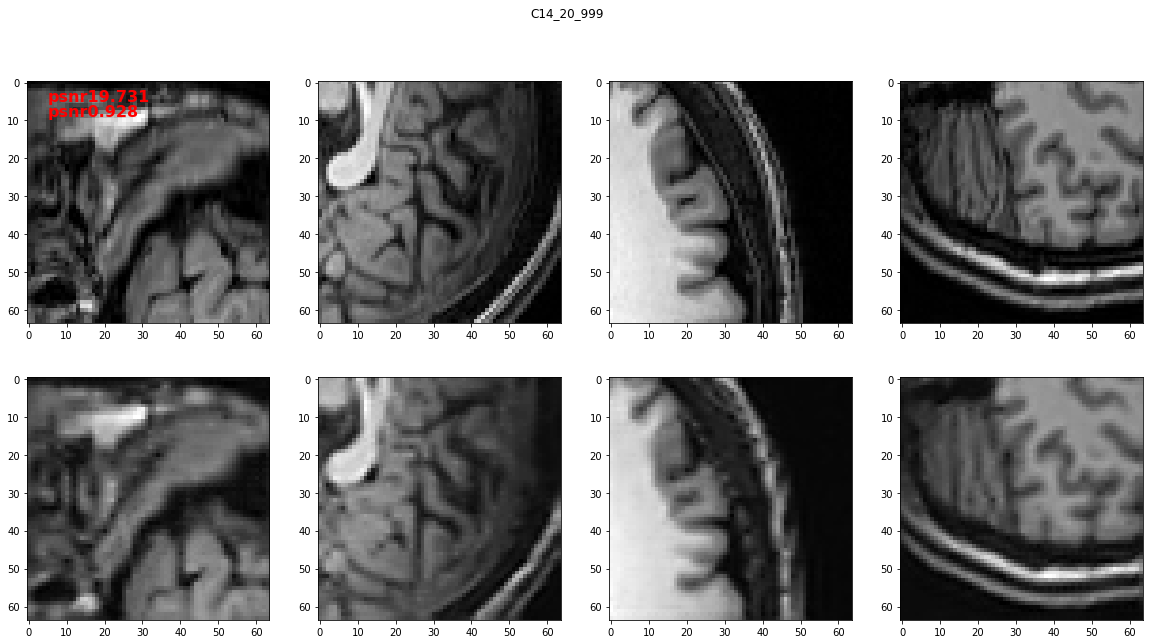

In [11]:
plot_val(sr,hr_arr,"C14_20_999")

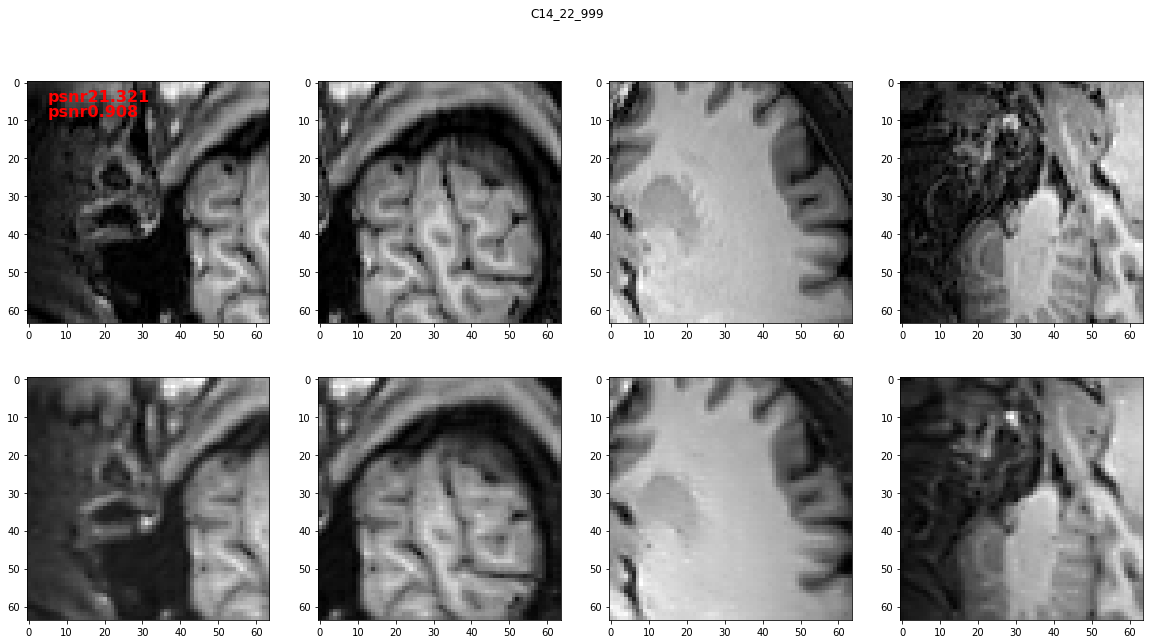

In [16]:
plot_val(sr,hr_arr,"C14_22_999")

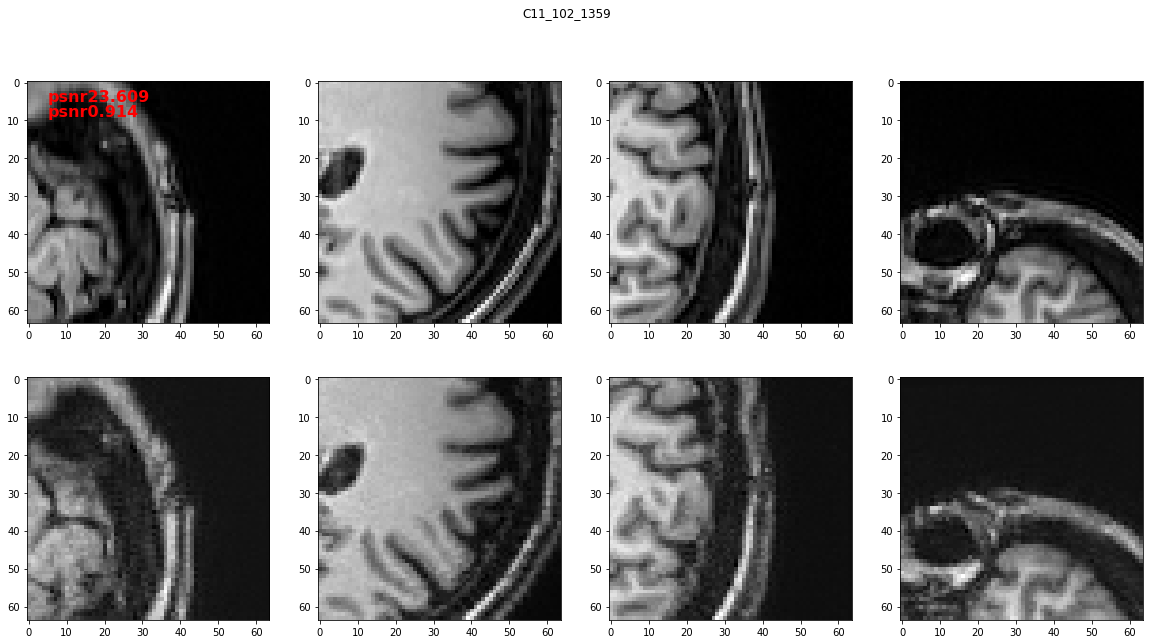

In [43]:
plot_val(sr,hr_arr,"C11_102_1359")

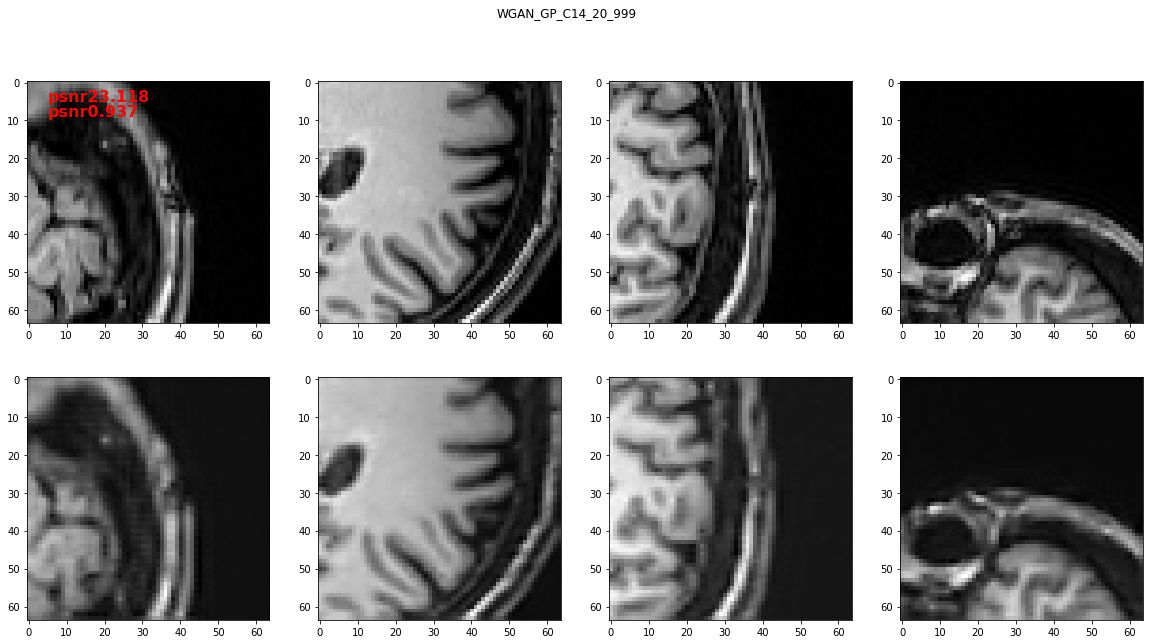

In [49]:
plot_val(sr,hr_arr,"WGAN_GP_C14_20_999")

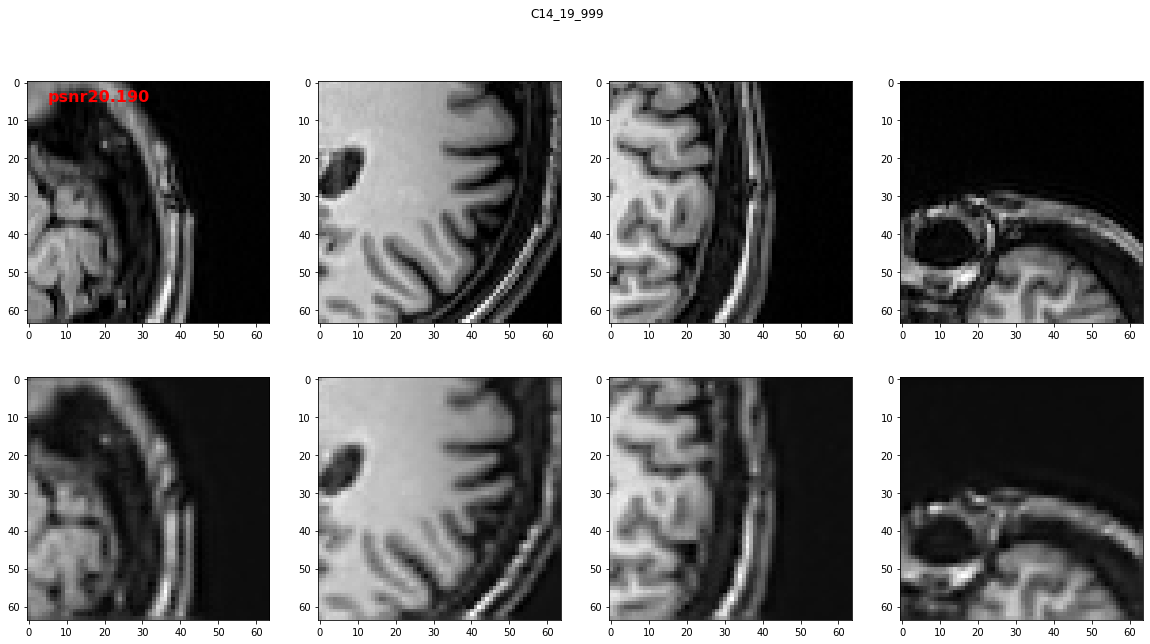

In [30]:
plot_val(sr,hr_arr,"C14_19_999")

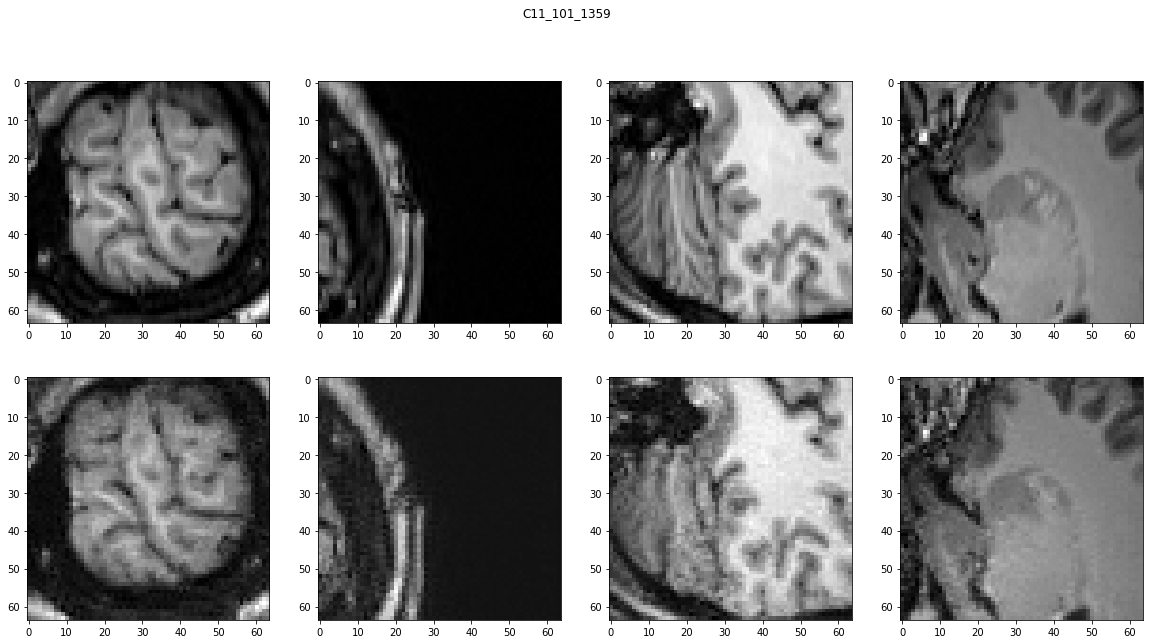

In [21]:
plot_val(sr,hr_arr,"C11_101_1359")

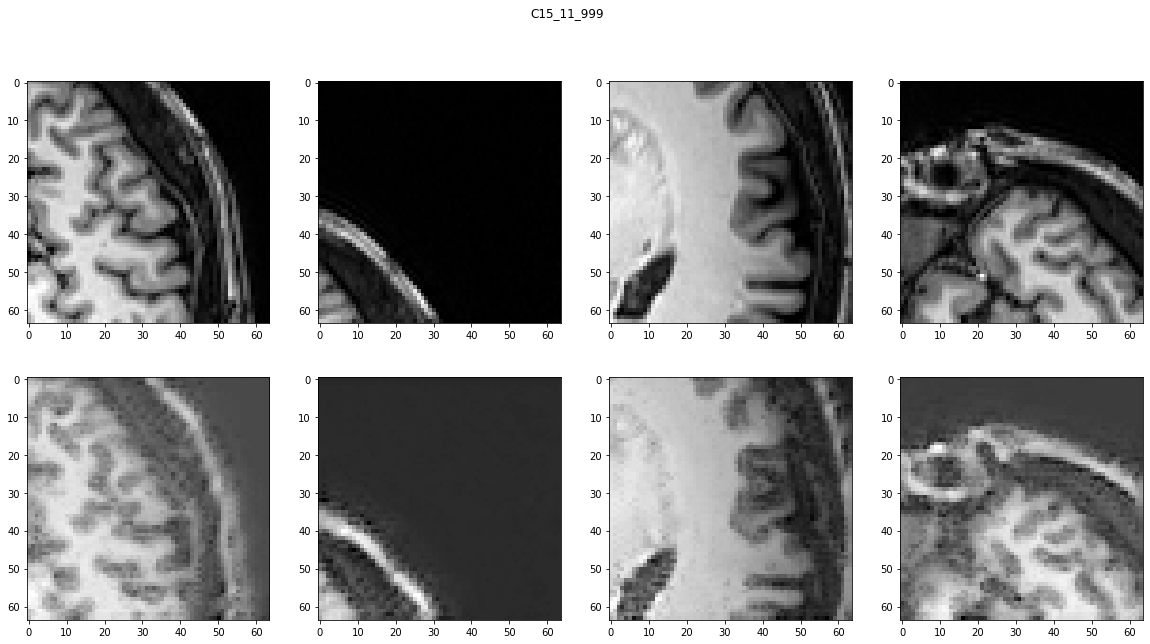

In [25]:
plot_val(sr,hr_arr,"C15_11_999")

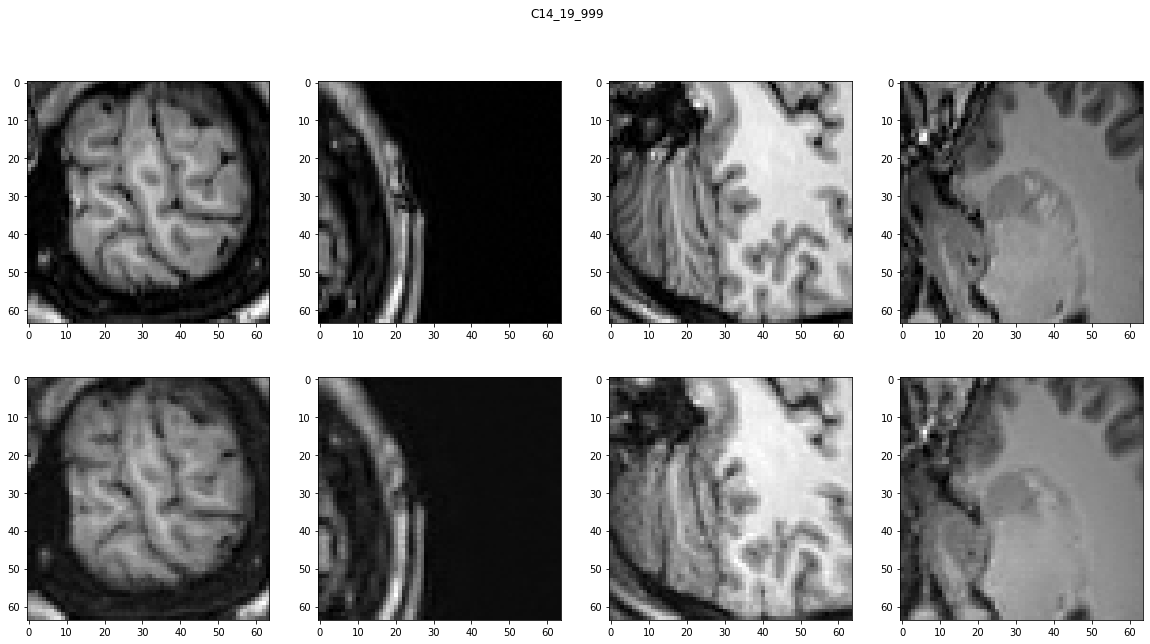

In [15]:
plot_val(sr,hr_arr,"C14_19_999")

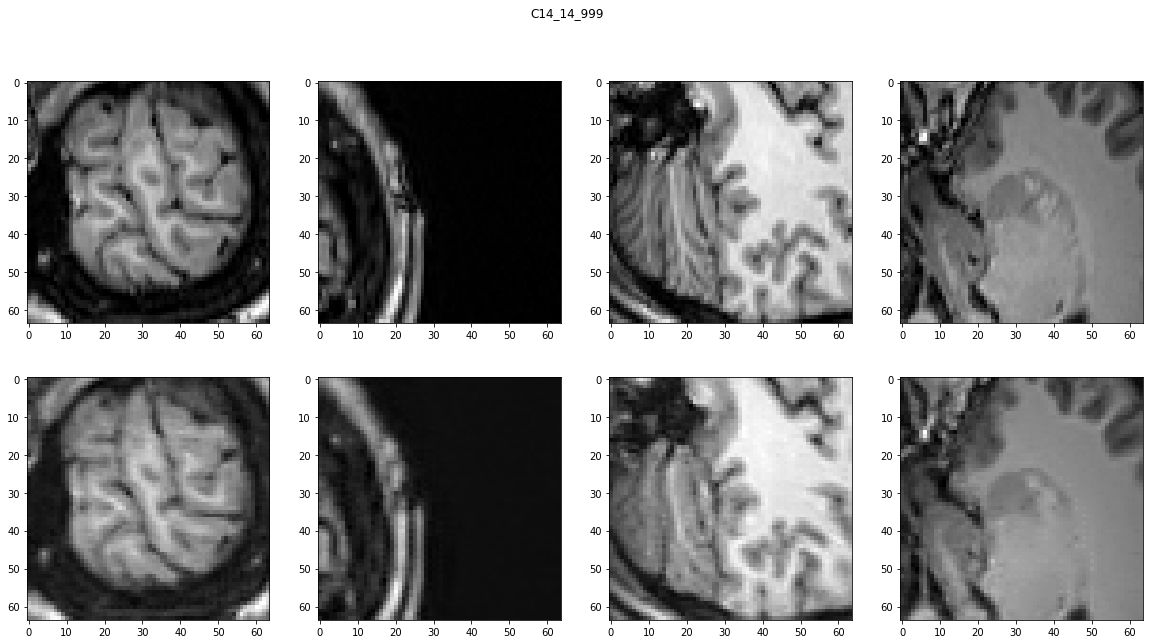

In [11]:
plot_val(sr,hr_arr,"C14_14_999")

## X64 complete crop assemble

In [14]:
import nibabel as nb
import numpy as np
import torch

import os
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader

import glob
import re

from data.ESRGAN_3d_dataset import *
#from model.ESRGAN_3d_model_Copy import * # for WGAN-GP
from model.model_VGG16_IN import * # for ESRGAN_VGG16_IN
#from model.model_pretrain_resnet import *

#from model.toy_model_3d import * # for c11
#rom model.model_VGG19_LN import *   #for ESRGAN_19
from utils.utils import *

In [15]:
def assemble_x64(file_list:list):
    '''
    file_list : list of crops' names
    '''
    # normal assembling for X64
    X_NUM,Y_NUM,Z_NUM = [int(np.floor(x/64)) for x in nii_whole.shape]
    tmp_arr = np.ones((X_NUM*64,Y_NUM*64,Z_NUM*64)).astype(dtype = np.float32) # allocate output image w/ appending size
    i = 0 # iterator
    for idx in range(0,X_NUM):
        for idy in range(0,Y_NUM):
            for idz in range(0,Z_NUM):                
                    tmp_arr[64*idx:64*(idx+1), 64*idy:64*(idy+1), 64*idz:64*(idz+1)] = nb.load(file_list[i]).get_fdata()
                    i += 1
    return tmp_arr
# residual assembling for X16
def assemble_img_X64(crop_list:list,new_shape,scale:int=1):
    X_NUM,Y_NUM,Z_NUM = [int(np.ceil(x/64)) for x in new_shape] # num of non-overlapping crops along each dim
    CROP_SIZE = 64*scale
    tmp_arr = np.ones((X_NUM*CROP_SIZE,Y_NUM*CROP_SIZE,Z_NUM*CROP_SIZE)).astype(dtype = np.float32) # allocate output image w/ appending size
    i = 0 # iterator
    for idz in range(0,Z_NUM):
        for idy in range(0,Y_NUM):
            for idx in range(0,X_NUM):                
                tmp_arr[CROP_SIZE*idx:CROP_SIZE*(idx+1), CROP_SIZE*idy:CROP_SIZE*(idy+1), CROP_SIZE*idz:CROP_SIZE*(idz+1)] = crop_list[i]
                i += 1
    return tmp_arr     

In [16]:
def crop_img3d_2list(img_path,crop_size,*step_size,path_save='',norm=False):
    '''
    Args: 
        0: image path for loading
        1: image saving folder
        2: crop_size
        *3: step_size for xyz
    Output: 
        list | coordinate order |
             |    x > y > z     |
        new image shape : tuple
    '''
    print(f'****image\t {img_path.split("/")[-1]} is being cropped****')
    step_size_x,step_size_y,step_size_z = step_size if (len(step_size) == 3) else quit("specify x,y,z step size plz!")
    img = nb.load(img_path)
    
    # pad image
    pad_num = [int((np.ceil(x/64)*64-x)/2) for x in img.get_fdata().shape] # pad all dim to be divided by 64
    img_arr = img.get_fdata()
    if norm:
        img_arr /= img_arr.max()
    pad_img = np.pad(img_arr,((pad_num[0],pad_num[0]),(pad_num[1],pad_num[1]),(pad_num[2],pad_num[2])),'constant',constant_values=(0,))
    pad_nii = nb.Nifti1Image(pad_img,np.eye(4))
    
    imgs = []
    print(pad_img.shape,'\t',img.get_filename())
    for k in range(0,(pad_img.shape[2]-crop_size)+step_size_x,step_size_x):
        for j in range(0,(pad_img.shape[1]-crop_size)+step_size_y,step_size_y):
            for i in range(0,(pad_img.shape[0]-crop_size)+step_size_z,step_size_z):                
                img_c = pad_nii.slicer[i:i+crop_size,j:j+crop_size,k:k+crop_size]
                #img_c = img_c.to_filename(f'{path_save}/{img.get_filename().split("/")[-1].split(".")[0]}_{i}_{j}_{k}.nii') # not using .gz for acceleration
                imgs.append(img_c.get_fdata())
    return imgs,pad_img.shape

### Assembling from cropped(after SR) images

In [5]:
from model.model_base import img2lr

In [6]:
def produce(model,crop_img,scale:int,device,hr_shape=64):
    model.eval()
    with torch.no_grad():
        _,data_tensor_lr = img2lr(crop_img,device,hr_shape,scale)
        res_tensor = model(data_tensor_lr.to(device))
    return res_tensor.detach().squeeze().cpu().numpy()

In [7]:
crop_list,newshape = crop_img3d_2list("/ptmp/wangqi/transfer_folder/LS2009.nii.gz",64,64,64,64)

****image	 LS2009.nii.gz is being cropped****
(256, 320, 320) 	 /ptmp/wangqi/transfer_folder/LS2009.nii.gz


In [8]:
device  = torch.device('cuda:0')
hr_shape = 64 # input orig crop size
#model_name = 'Jupyter_c14_Crop_generator_15_999'
#model_name = 'c11_generator_102_1359'
scale = 1

In [17]:
#ckp = torch.load("../saved_models/Jupyter_C14_Crop_38_999.pth")
ckp = torch.load("../saved_models/c15_Crop_83_999.pth")
#ckp = torch.load("../saved_models/pre-trained_c15_Crop_57_999.pth")

In [18]:
model_name = ckp['Gnet_state_dict']
#model_name = 'c11_generator_102_1359'

In [19]:
new_model = Generator()
new_model.eval()
new_model.to("cuda:0")
new_model.load_state_dict(model_name)
#new_model.load_state_dict(torch.load(f'../saved_models/{model_name}.pth'),strict = False)

<All keys matched successfully>

In [28]:
from data.ESRGAN_3d_dataset import Val_Dataset

ImportError: cannot import name 'Val_Dataset' from 'data.ESRGAN_3d_dataset' (/raven/u/wangqi/torch_env/crop_gan/mains/data/ESRGAN_3d_dataset.py)

In [20]:
tmp = [produce(new_model,x,scale,device) for x in crop_list]

In [21]:
new_img = assemble_img_X64(tmp,newshape,scale)

In [22]:
if scale == 1:
    tmp_img = new_img[24:-24,10:-10,:] # used for demean_LS2001 scale =1
elif scale ==2 :
    tmp_img = new_img[48:-48,20:-20,:] # used for demean_LS2001 scale =2

In [9]:
import torch.nn.functional as F
lr = F.interpolate(torch.tensor(hr).unsqueeze(0).unsqueeze(0),scale_factor=0.5)

In [11]:
linear_hr = F.interpolate(lr,scale_factor=2).squeeze().numpy()

In [16]:
# cropping image for HCP_v3
tmp_img = new_img[60:-60,9:-9,60:-60]

In [23]:
hr = nb.load("/ptmp/wangqi/transfer_folder/LS2009.nii.gz").get_fdata()

In [16]:
from skimage.metrics import peak_signal_noise_ratio

In [23]:
new_tmp = new_img[30:-30,4:-5,30:-30]

In [24]:
from utils import *
import matplotlib.pyplot as plt

# WGAN-GP-SR VS ESRGAN visualization
- [x] WGAN-GP-SR Shows too blur content than ESRGAN, due to lack of feature matching
- [x] ESRGAN did not match better intensities than WGAN-GP, causing some no-existing pattern in the brain

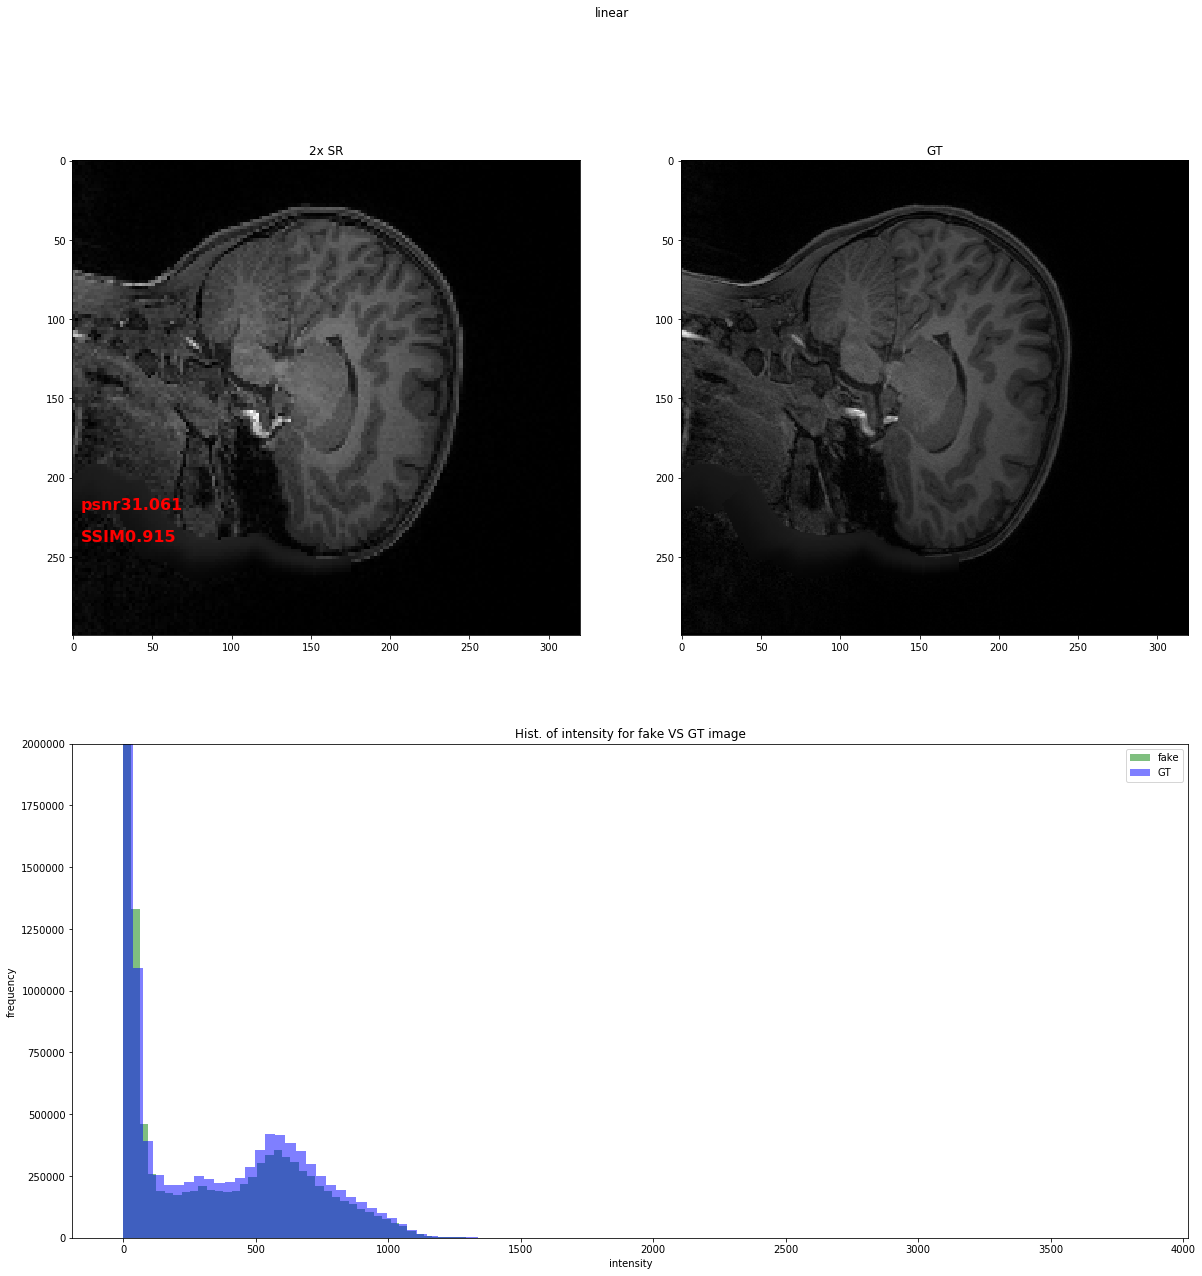

In [42]:
plot_vis(linear_hr,hr,title="linear")

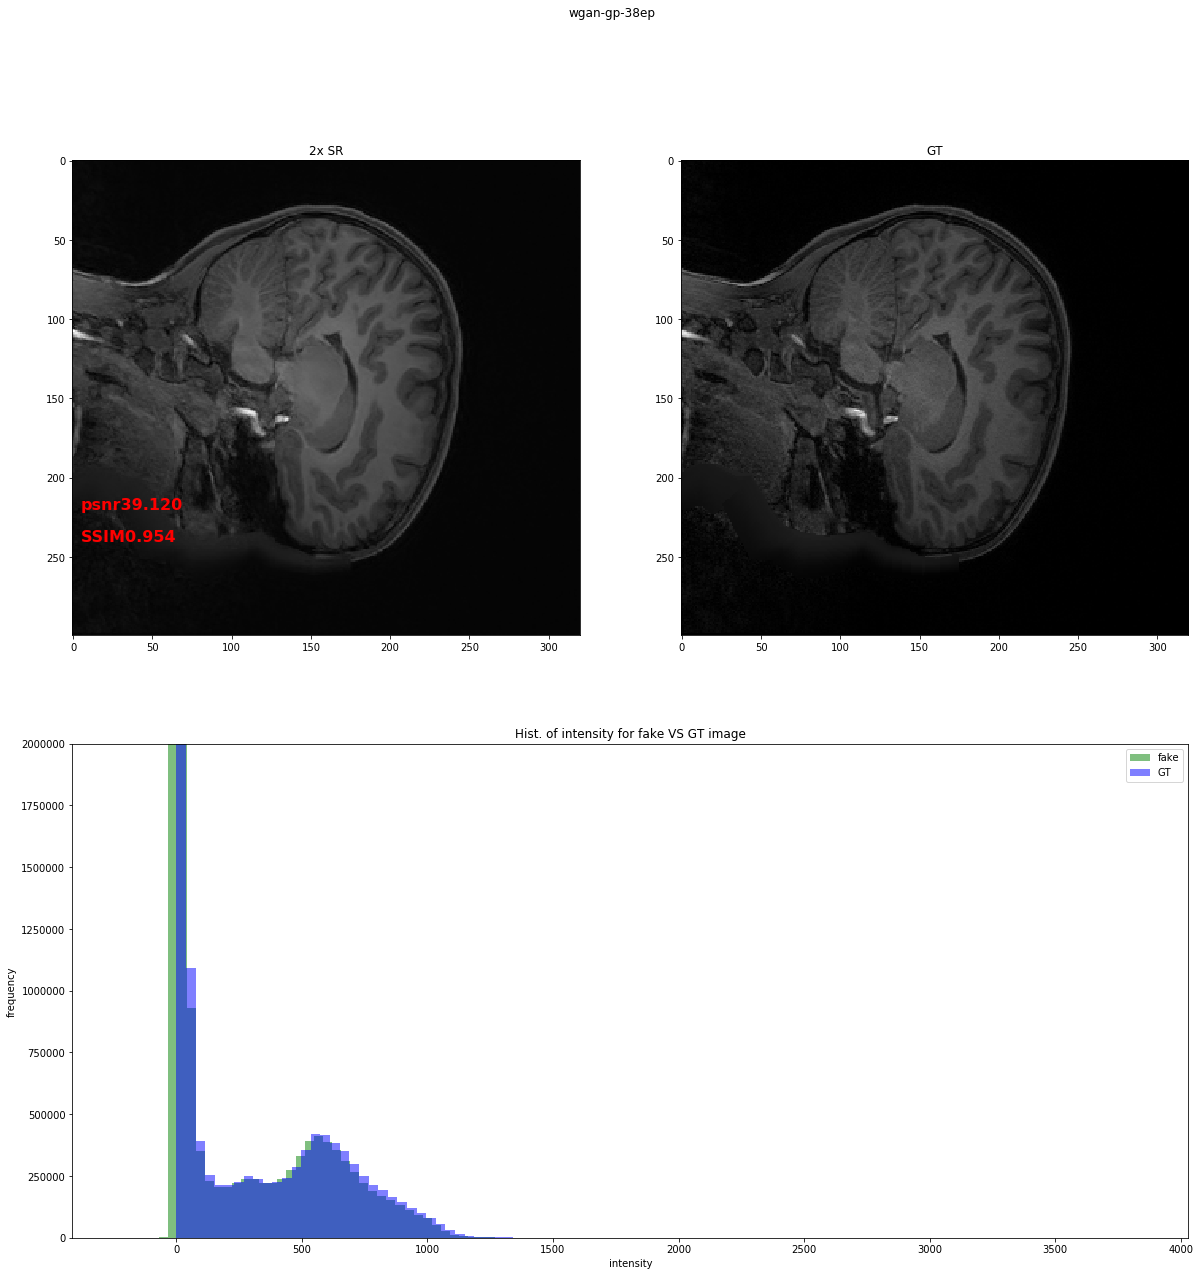

In [42]:
plot_vis(tmp_img,hr,title="wgan-gp-38ep")

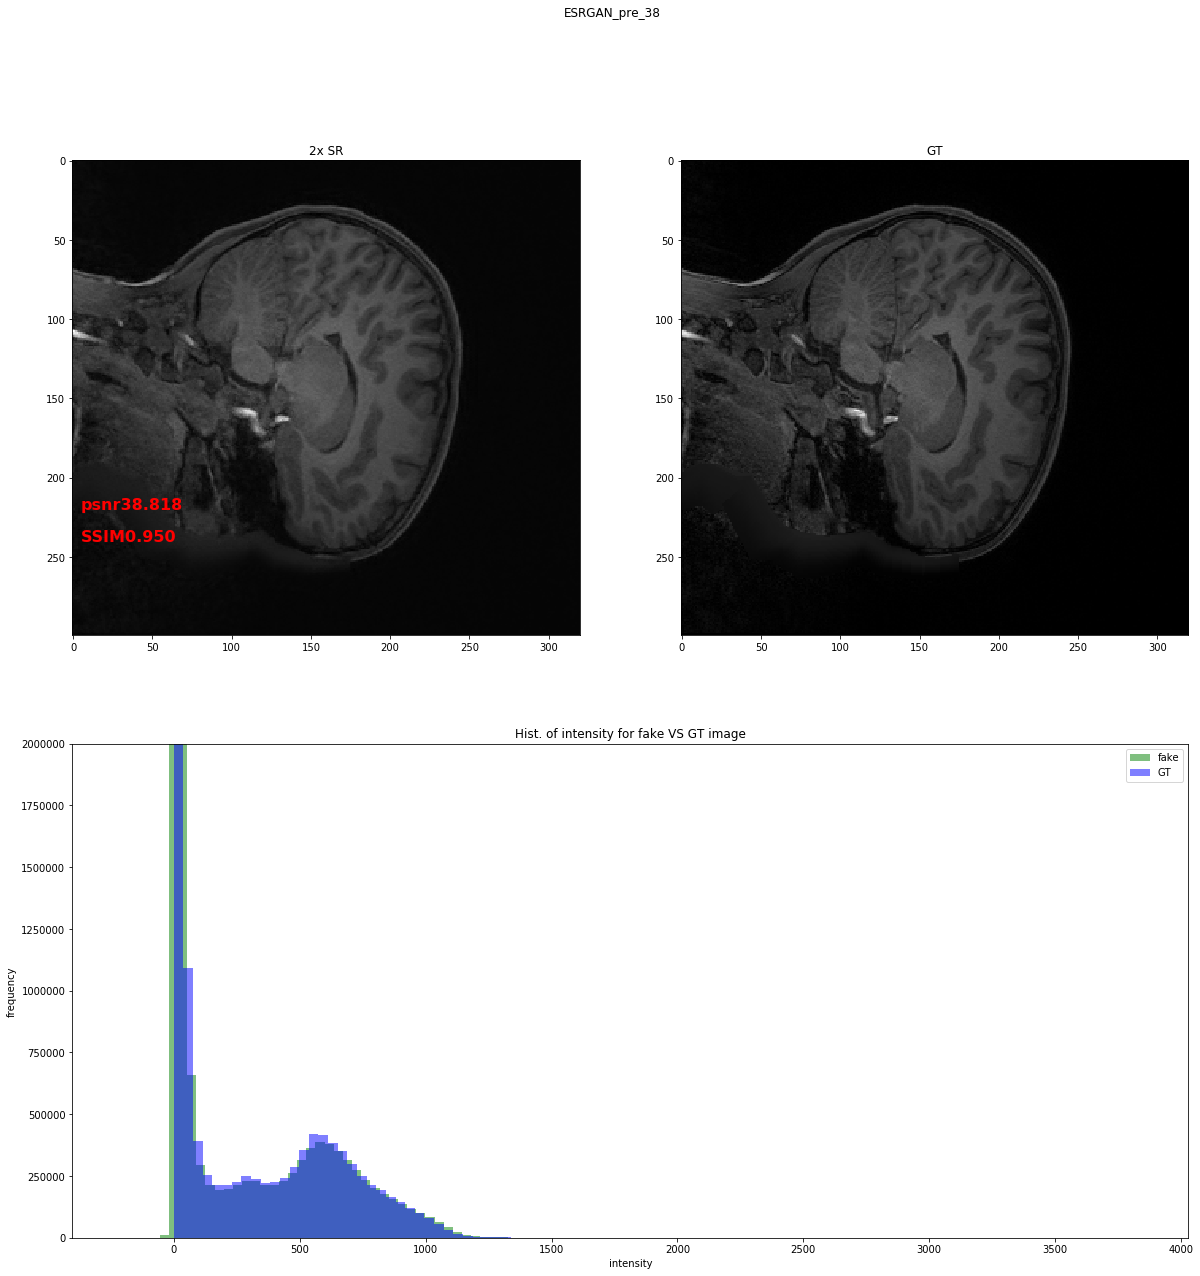

In [65]:
plot_vis(tmp_img,hr,title="ESRGAN_pre_38")

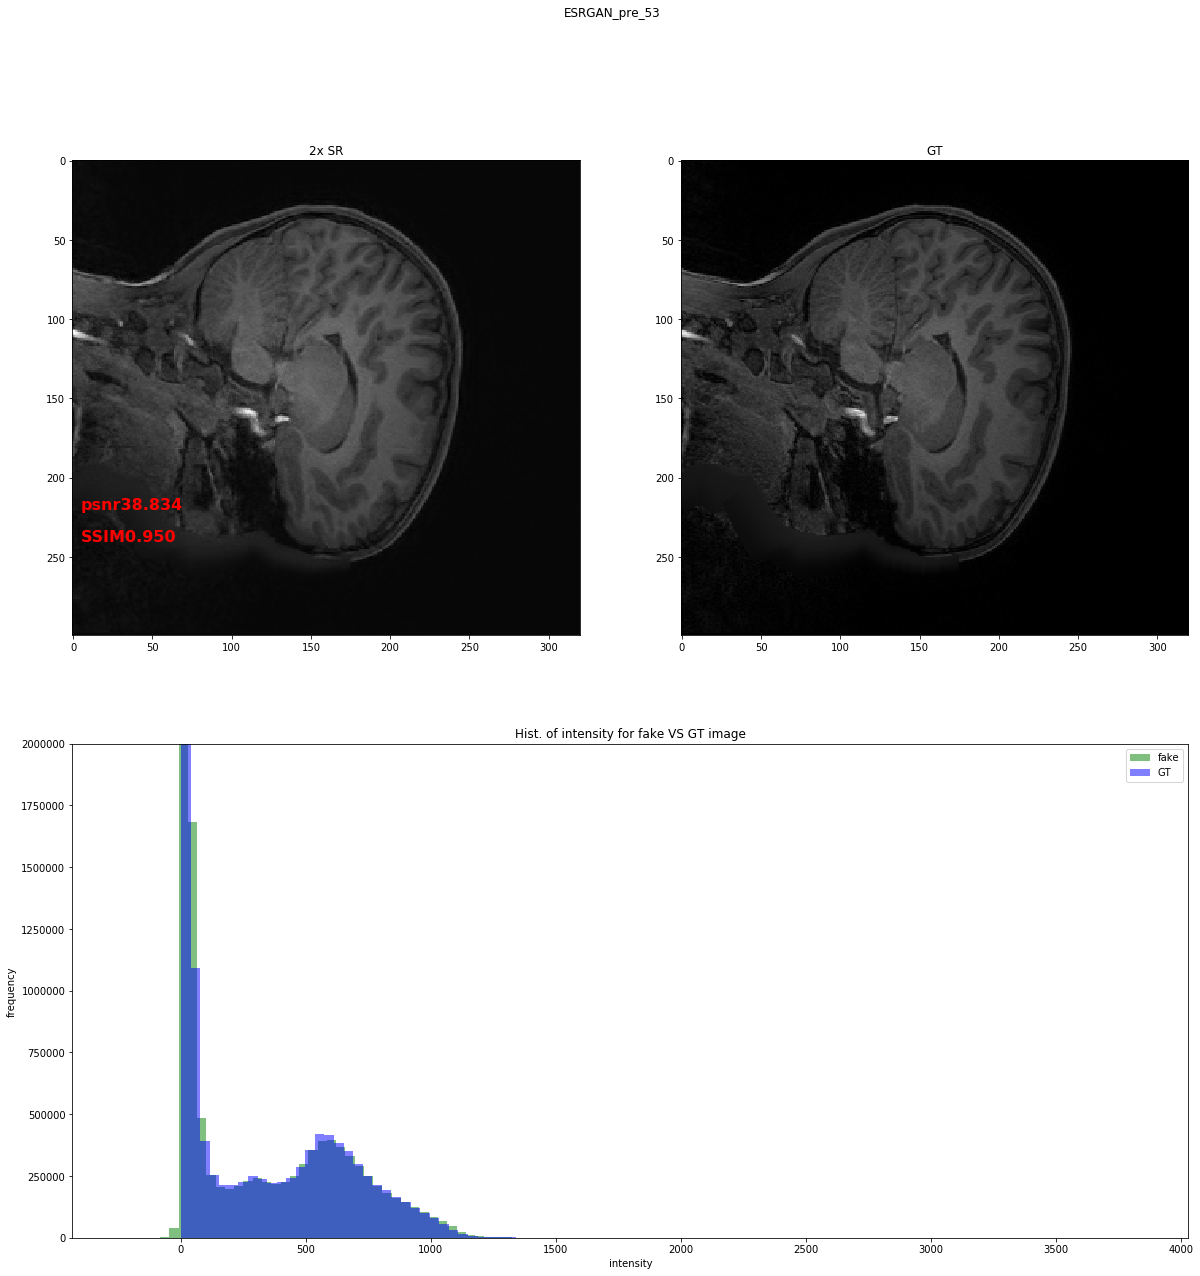

In [34]:
plot_vis(tmp_img,hr,title="ESRGAN_pre_53")

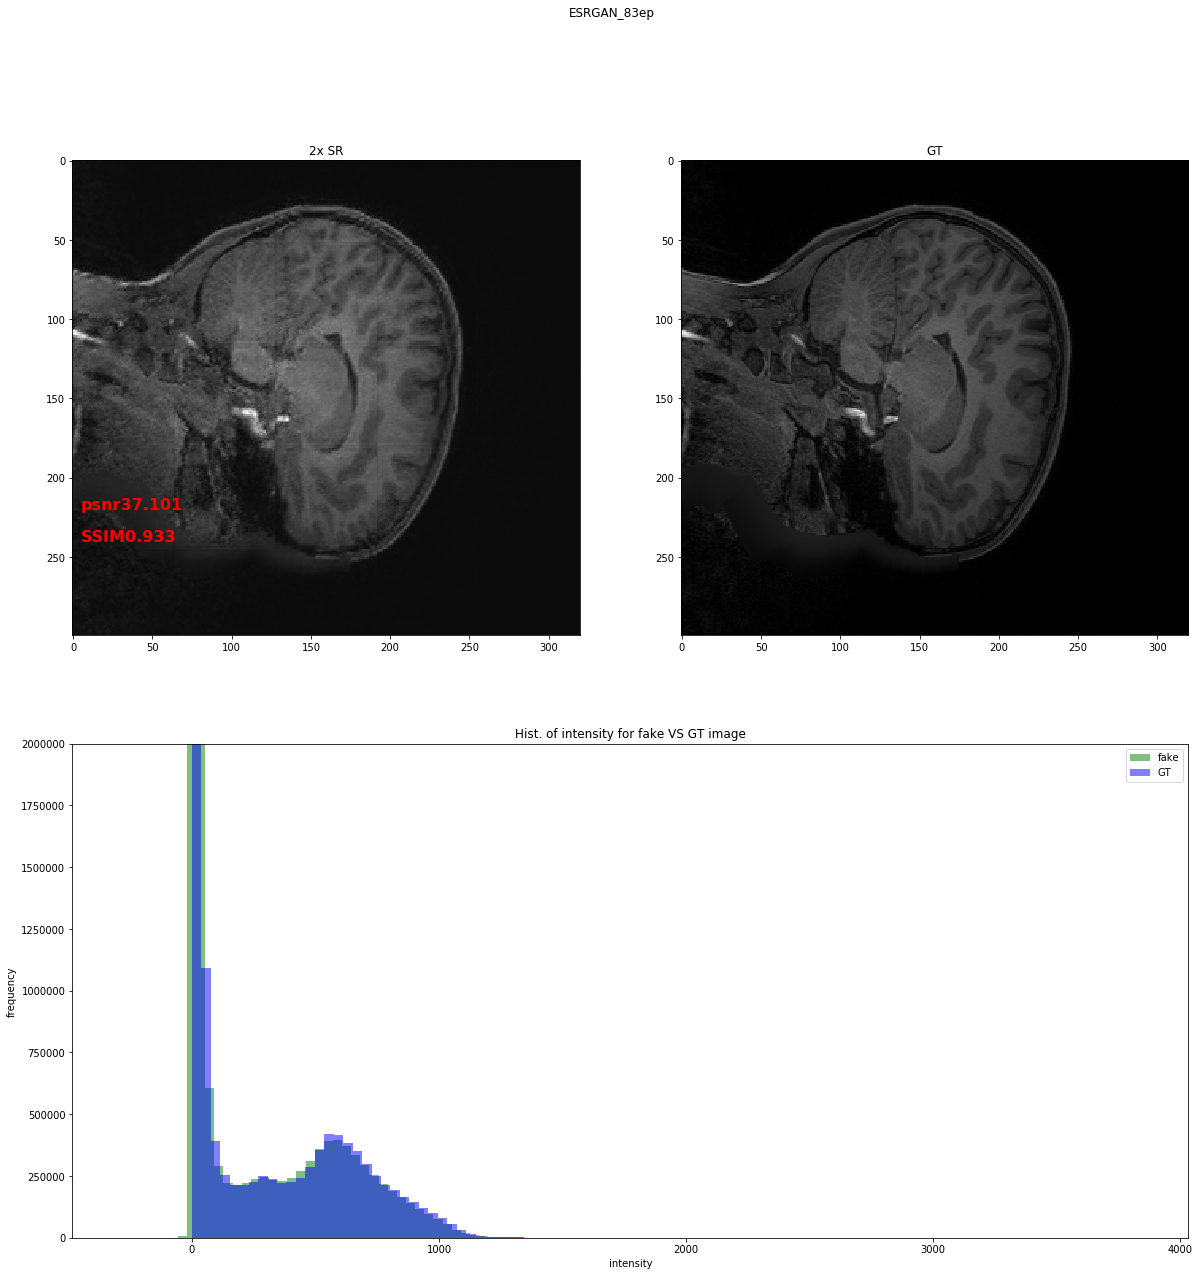

In [27]:
plot_vis(tmp_img,hr,title="ESRGAN_83ep")

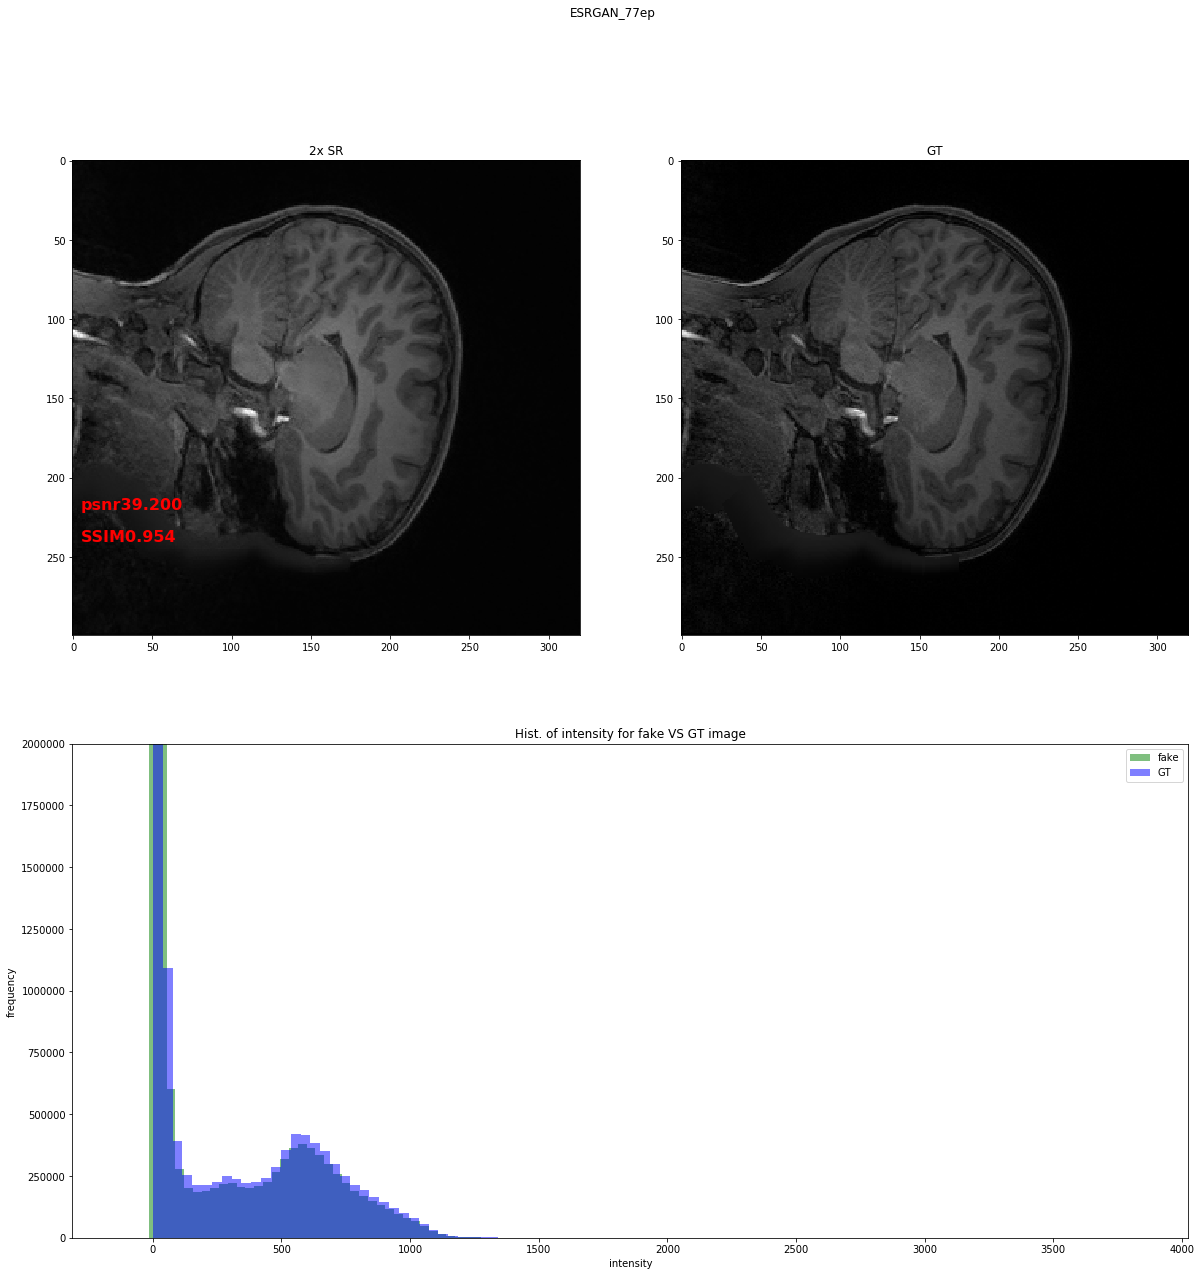

In [26]:
plot_vis(tmp_img,hr,title="ESRGAN_77ep")

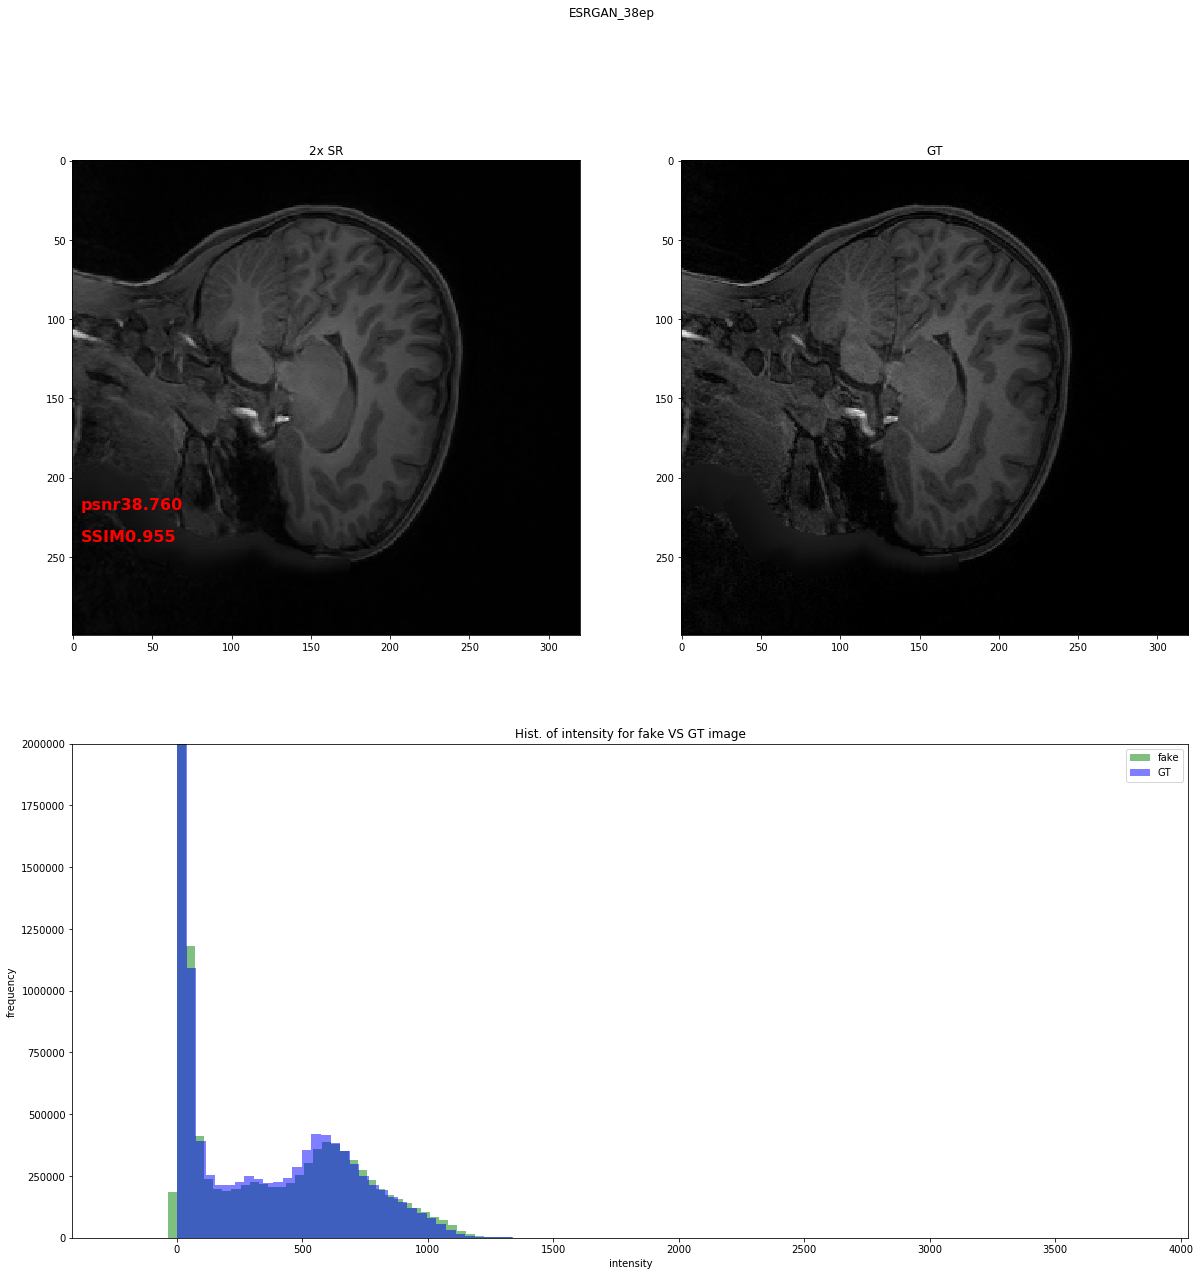

In [57]:
plot_vis(tmp_img,hr,title="ESRGAN_38ep")

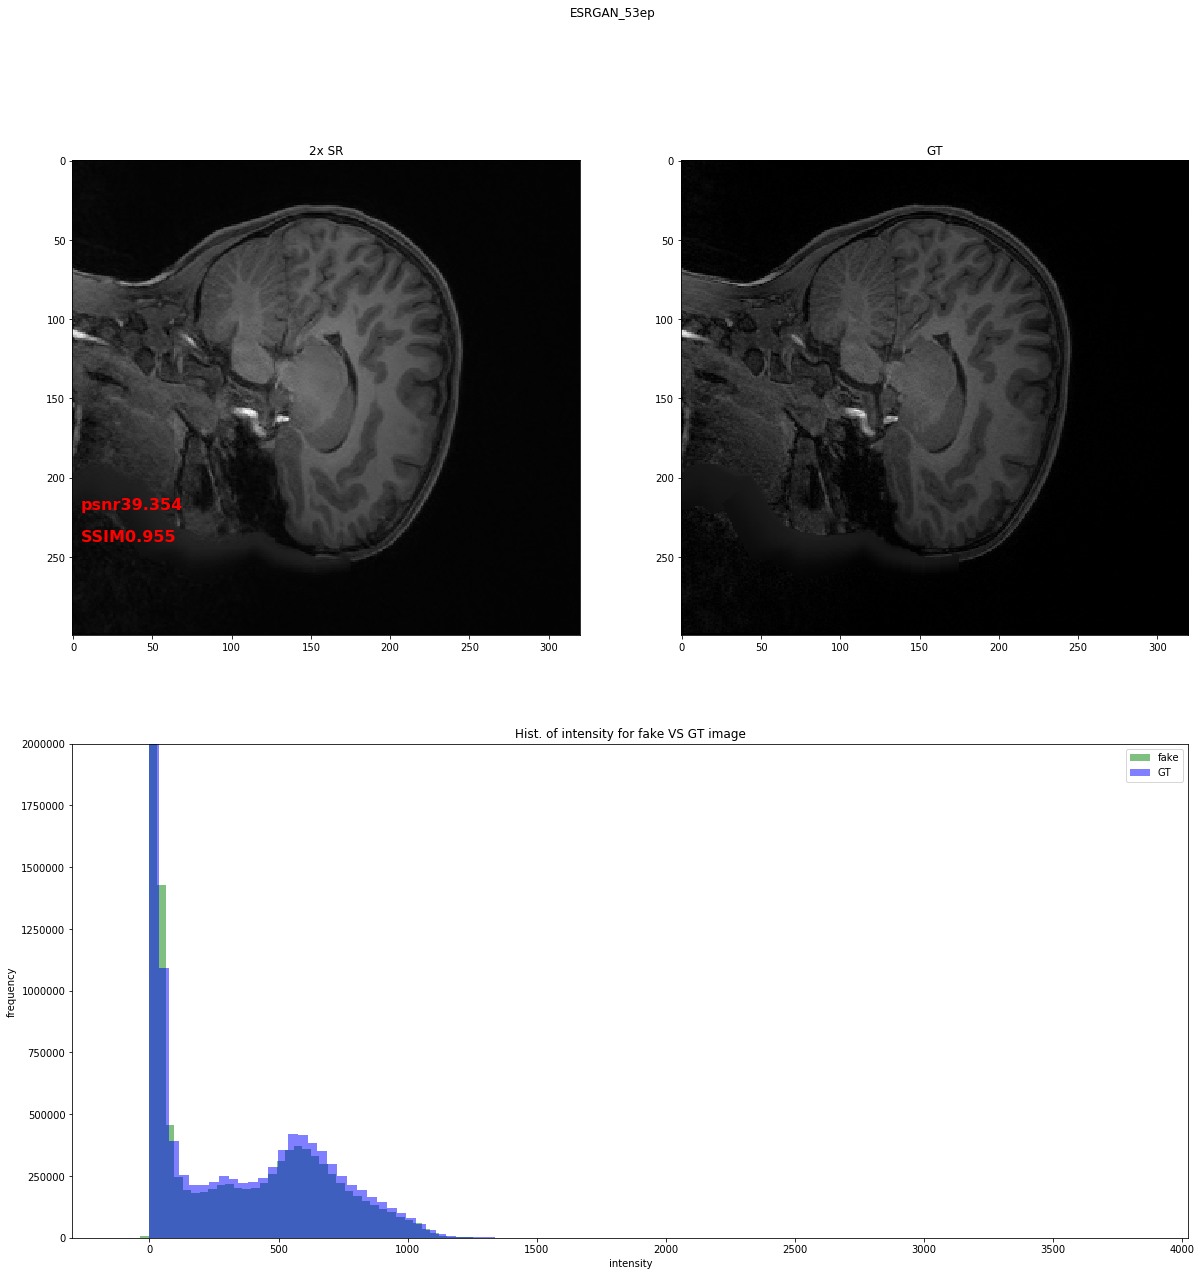

In [50]:
plot_vis(tmp_img,hr,title="ESRGAN_53ep")

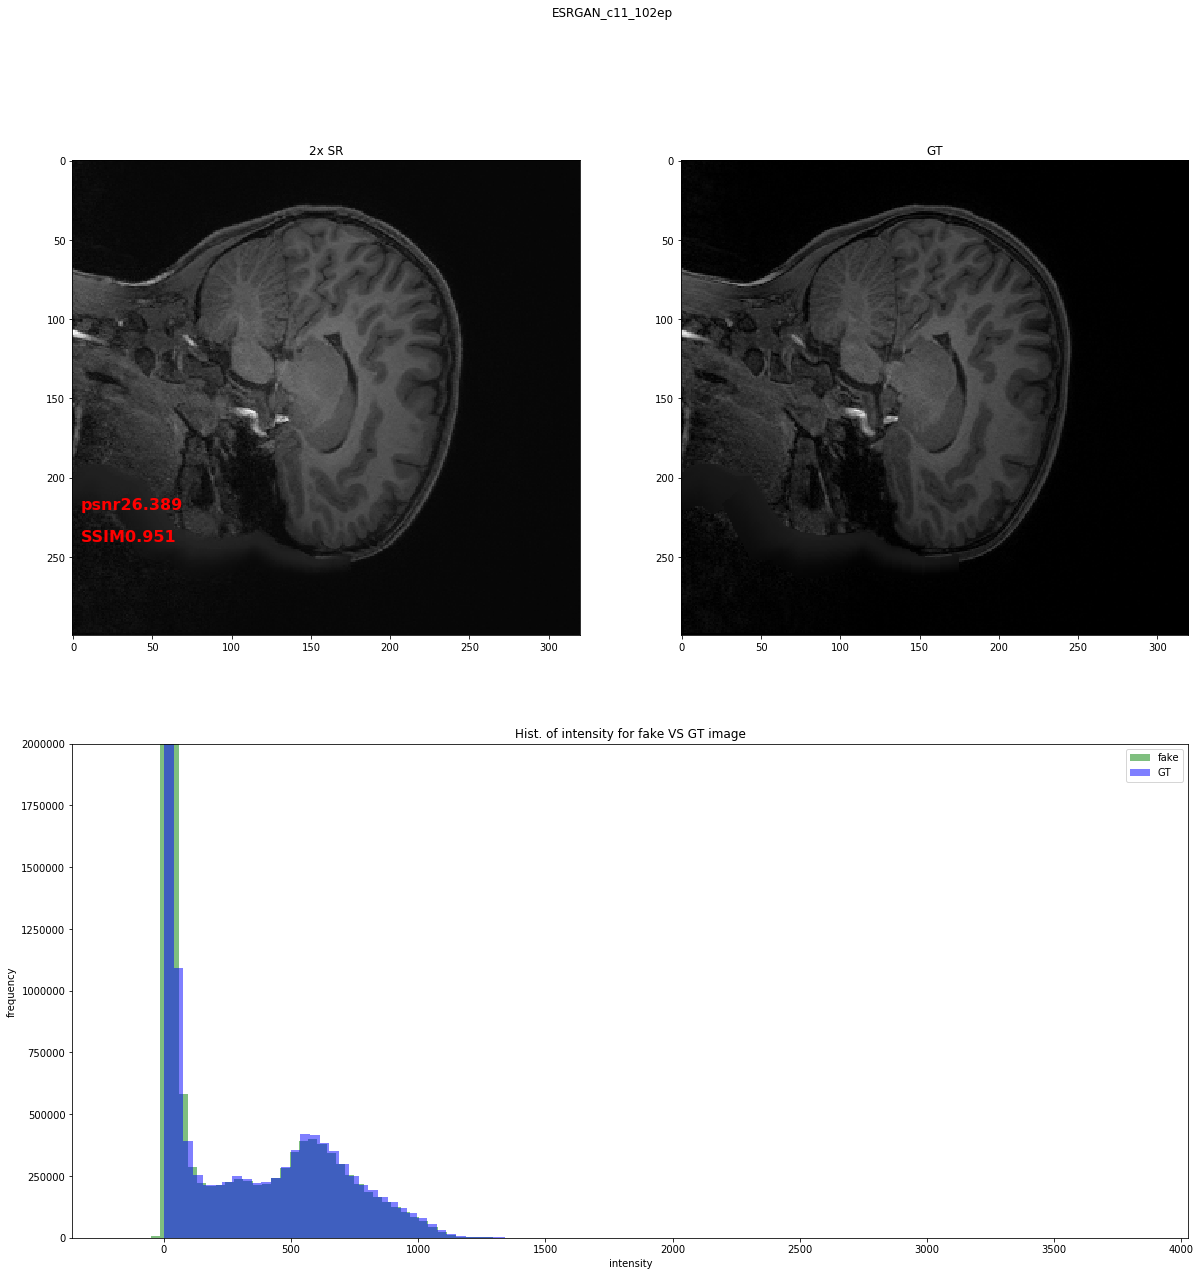

In [89]:
plot_vis(tmp_img,hr,title="ESRGAN_c11_102ep")

In [26]:
def plot_vis(fake_img,gt,title:str,slice_num=121):
    with torch.no_grad():
        psnr_v = psnr(fake_img,gt)
        ssim_v = ssim(fake_img,gt)
    
    fig = plt.figure(figsize=(20,20))
    ax1 = plt.subplot(221)
    ax1.imshow(fake_img[slice_num],cmap='gray')
    ax1.title.set_text("2x SR")
    ax2 = plt.subplot(222)
    ax2.imshow(gt[slice_num],cmap='gray')
    ax2.title.set_text("GT")
    fig.suptitle(title)
    ax3 = plt.subplot(212)
    _,b,c = ax3.hist(fake_img.ravel(),100,facecolor='g',alpha=0.5,label='fake')
    _,b,c = ax3.hist(gt.ravel(),100,facecolor='b',alpha=0.5,label='GT')
    ax3.set_ylim(0,2000000)
    ax1.text(5,220,f"psnr{psnr_v:.3f}",fontdict={'color':'red','size':16,'weight':'bold'})
    ax1.text(5,240,f"SSIM{ssim_v:.3f}",fontdict={'color':'red','size':16,'weight':'bold'})
    ax3.legend()
    ax3.set_xlabel("intensity")
    ax3.set_ylabel("frequency")
    ax3.title.set_text("Hist. of intensity for fake VS GT image")

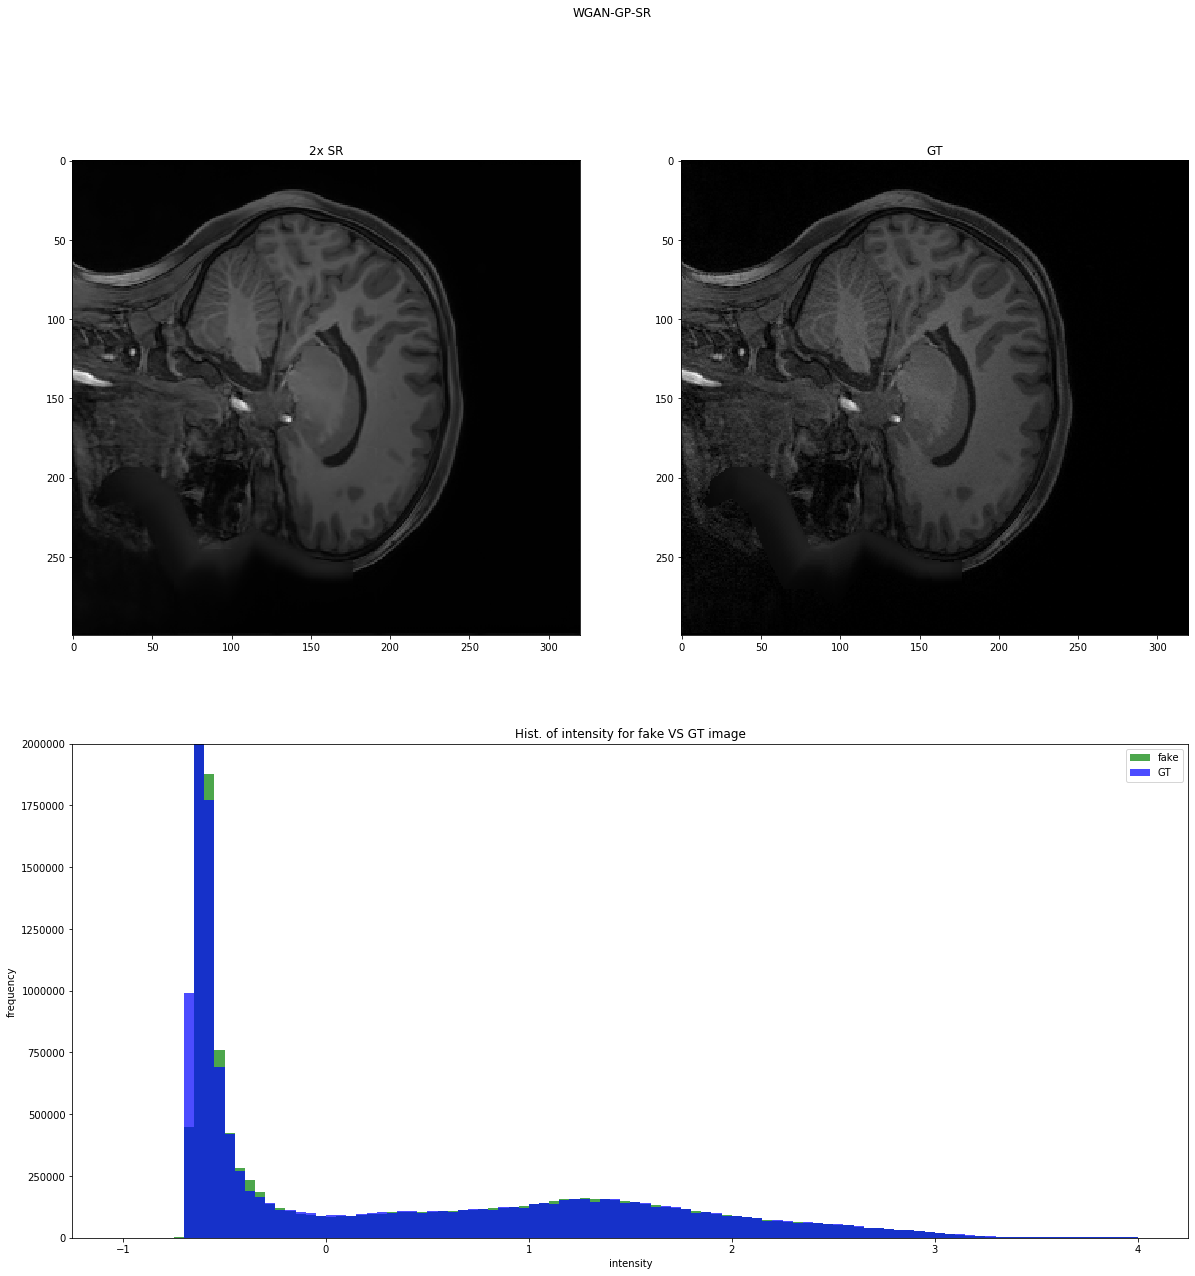

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(221)
ax1.imshow(tmp_img[121],cmap='gray')
ax1.title.set_text("2x SR")
ax2 = plt.subplot(222)
ax2.imshow(hr[121],cmap='gray')
ax2.title.set_text("GT")
fig.suptitle("WGAN-GP-SR")
ax3 = plt.subplot(212)
_,b,c = ax3.hist(tmp_img.ravel(),100,(-1,4),facecolor='g',alpha=0.7,label='fake')
_,b,c = ax3.hist(hr.ravel(),100,(-1,4),facecolor='b',alpha=0.7,label='GT')
ax3.set_ylim(0,2000000)
ax3.legend()
ax3.set_xlabel("intensity")
ax3.set_ylabel("frequency")
ax3.title.set_text("Hist. of intensity for fake VS GT image")

Text(0.5, 0.98, 'WGAN-GP-SR')

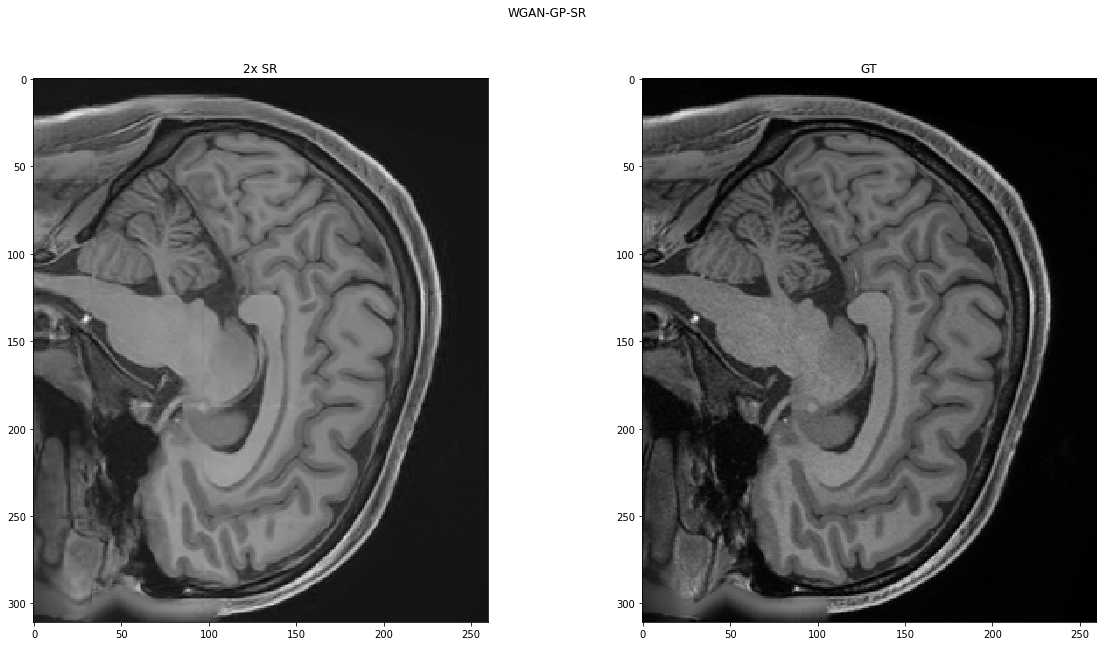

In [21]:
import matplotlib.pyplot as plt
fig,axe = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'width_ratios': [1, 1]})
ax1,ax2 = axe.ravel()
ax1.imshow(new_tmp[121],cmap='gray')
ax1.title.set_text("2x SR")
ax2.imshow(hr[121],cmap='gray')
ax2.title.set_text("GT")
fig.suptitle("WGAN-GP-SR")

Text(0.5, 0.98, 'epoch 49')

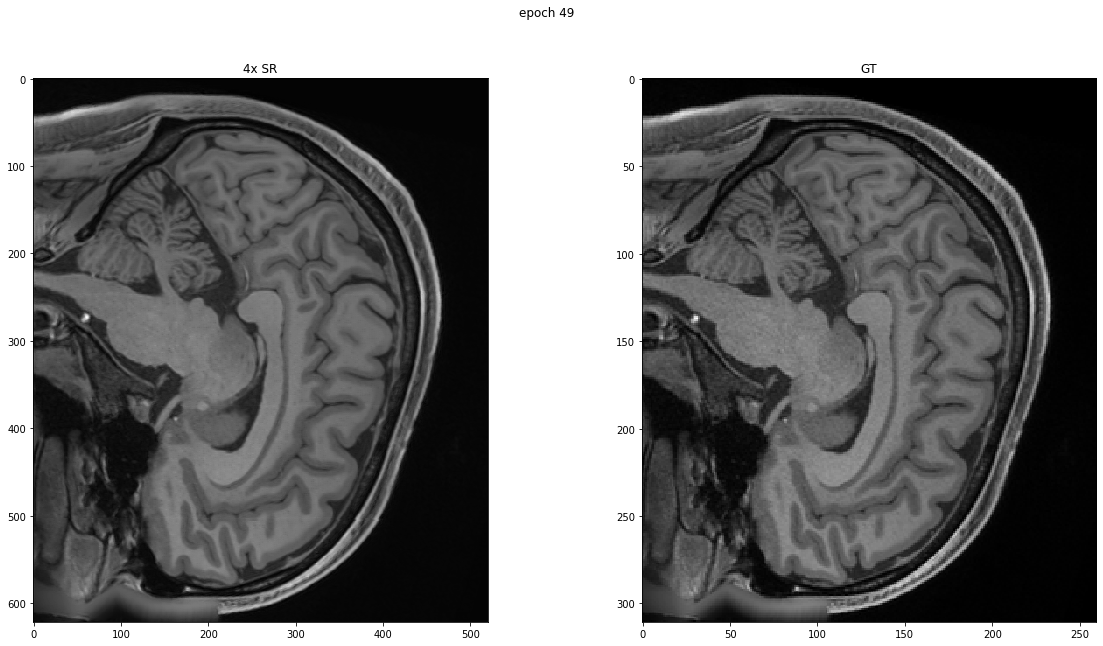

In [26]:
import matplotlib.pyplot as plt
fig,axe = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'width_ratios': [1, 1]})
ax1,ax2 = axe.ravel()
ax1.imshow(tmp_img[242],cmap='gray')
ax1.title.set_text("4x SR")
ax2.imshow(hr[121],cmap='gray')
ax2.title.set_text("GT")
fig.suptitle("WGAN-GP-SR")

Text(0.5, 0.98, 'epoch 49')

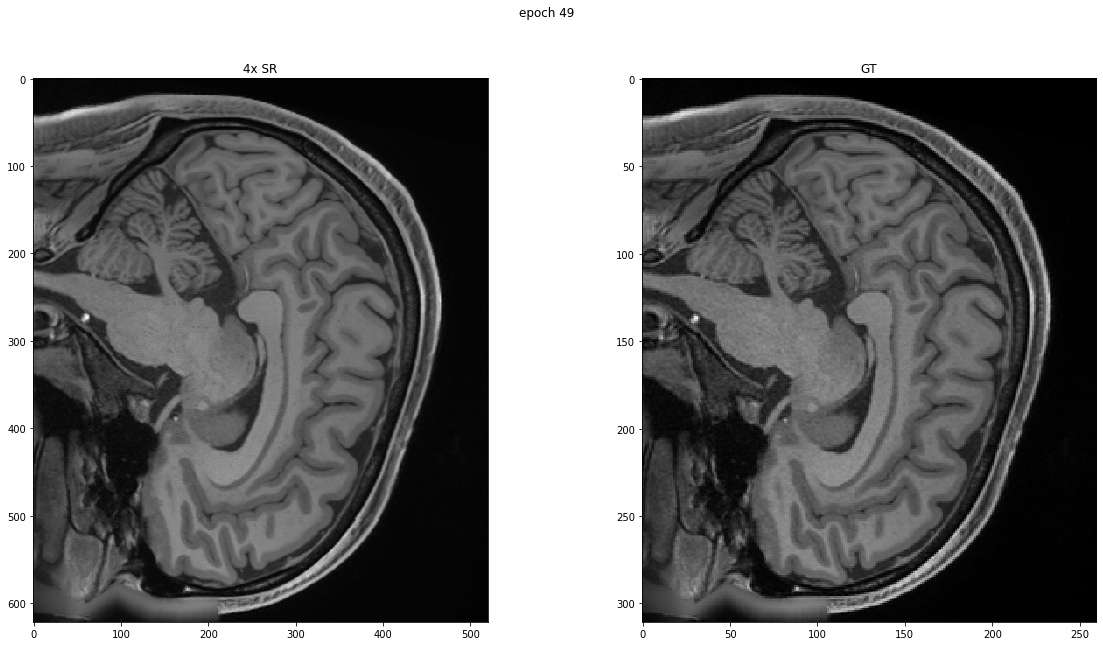

In [62]:
import matplotlib.pyplot as plt
fig,axe = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'width_ratios': [1, 1]})
ax1,ax2 = axe.ravel()
ax1.imshow(tmp_img[242],cmap='gray')
ax1.title.set_text("4x SR")
ax2.imshow(hr[121],cmap='gray')
ax2.title.set_text("GT")
fig.suptitle("epoch 49")

Text(0.5, 0.98, 'epoch 49')

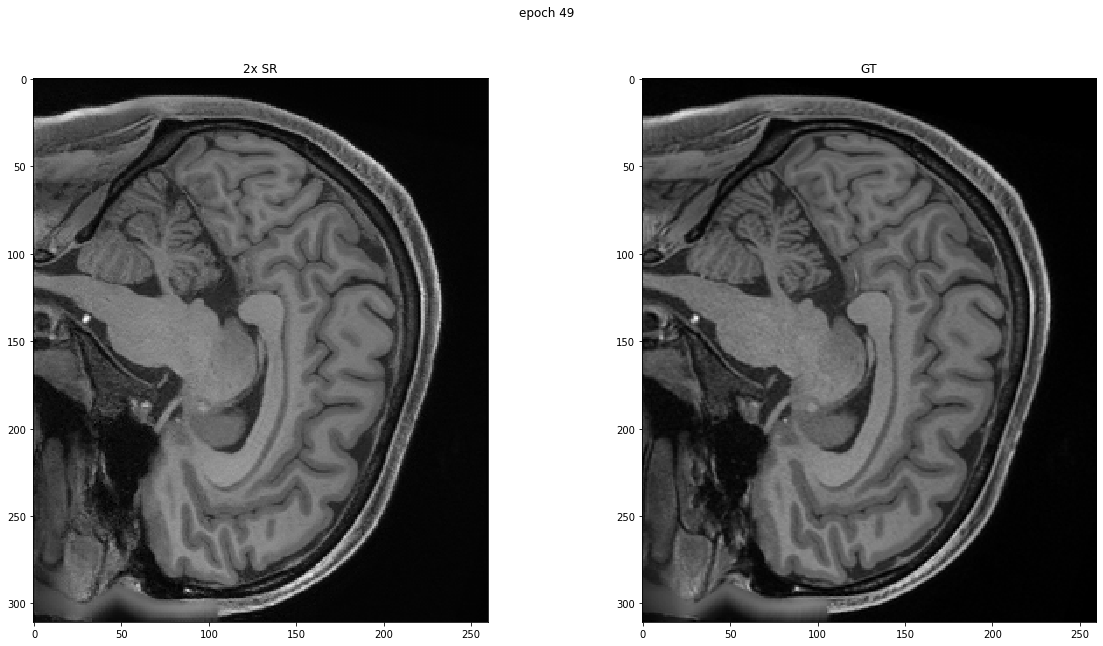

In [64]:
import matplotlib.pyplot as plt
fig,axe = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'width_ratios': [1, 1]})
ax1,ax2 = axe.ravel()
ax1.imshow(new_tmp[121],cmap='gray')
ax1.title.set_text("2x SR")
ax2.imshow(hr[121],cmap='gray')
ax2.title.set_text("GT")
fig.suptitle("epoch 49")

In [55]:
psnr(norm(new_tmp),norm(hr))

29.153352313106712

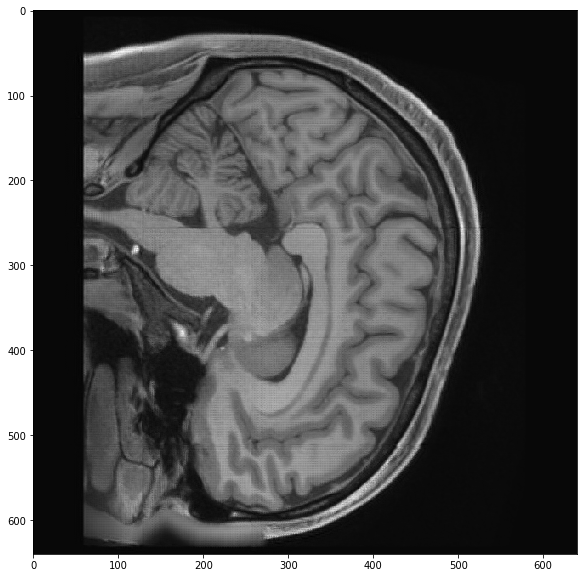

In [35]:
fg = plt.figure(figsize=(10,10))
plt.imshow(new_img[300],cmap='gray')

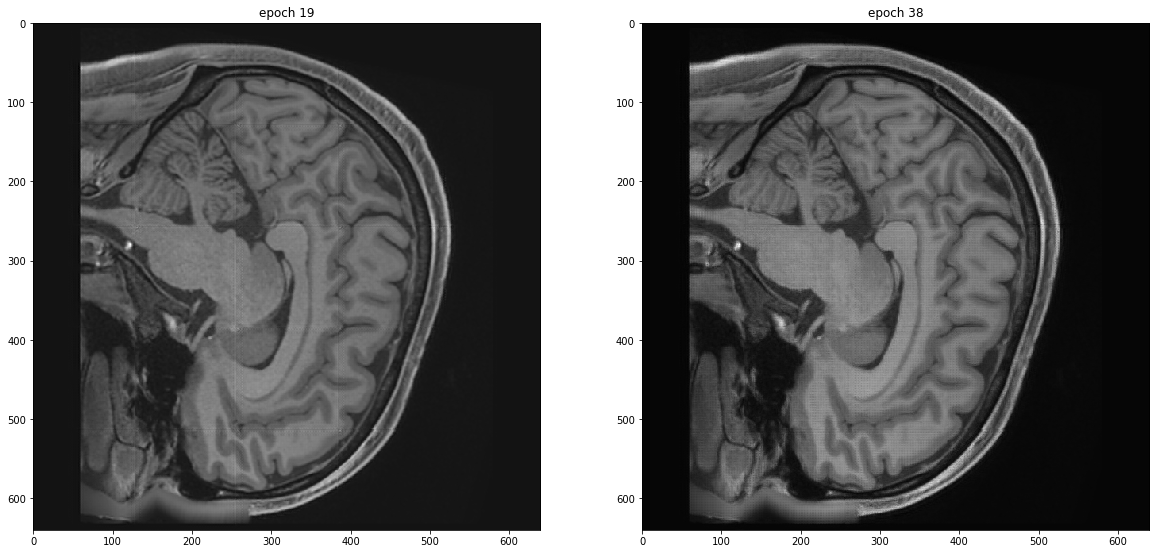

In [38]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(new_img_new[300],cmap='gray')
ax1.title.set_text('epoch 19')
ax2 = fig.add_subplot(122)
ax2.imshow(new_img_old[300],cmap='gray')
ax2.title.set_text('epoch 38')

# result of Jupyter_C14_19_999

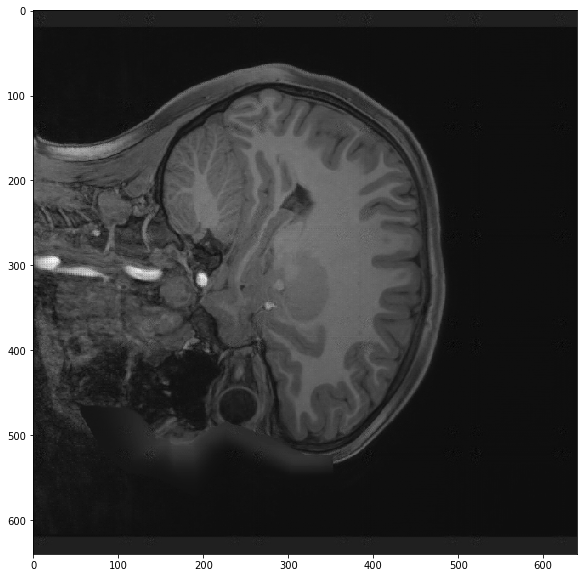

In [70]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.imshow(new_img[200],cmap='gray')

# result of C13_23ep_5439

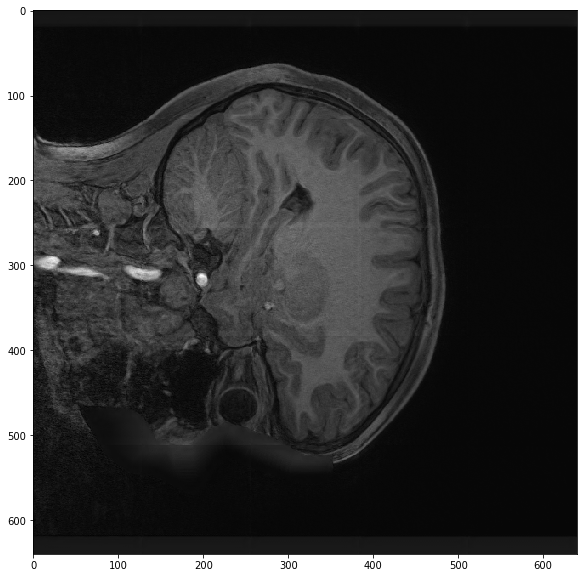

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.imshow(new_img[200],cmap='gray')

In [7]:
def produce(model,file_name:list,hr_shape:int,scale:int,device):
    '''
    Args:
        1 | model loaded
        2 | crop file list of a subject
        3 | HR image(GT) H(or W)
        4 | upscale factor
        5 | device 
    Output:
        1 | SR crop file list of a subj 
    '''
    img_list = [] # output crop list
    model.eval()
    with torch.no_grad():
        for i,image_name in tqdm(enumerate(file_name)): # crop list of same subj 
            _,data_tensor_lr = img2lr(image_name,device,hr_shape,scale)
            res_tensor = model(data_tensor_lr.to(device))
            img_list.append(res_tensor.detach().squeeze().cpu().numpy())
            #torch.cuda.empty_cache()
            #print(f'[{i} / {len(file_name)}]')
    return img_list

In [16]:
def iter_subj():
    files = glob.glob("/ptmp/wangqi/transfer_folder/LS200X_Norm/crops/LS2001*")
    file_name = sorted(files,key=lambda x:(float(re.findall("(\d+)",x)[-3]),float(re.findall("(\d+)",x)[-2]),float(re.findall("(\d+)",x)[-1])))
    img_list = produce(model, crop_list, hr_shape, scale, device)
    img_new = assemble_img(img_list)
    mask = mask_shape(img_new.shape)
    test_dst = np.reshape(img_new[mask],(mask.sum(axis=0)[0][0],mask.sum(axis=1)[0][0],mask.sum(axis=2)[0][0])) # mask out | 2.18 sec
    return test_dst

In [8]:
subj_list = list(set([os.path.basename(x).split('.')[0].split("_")[0] for x in glob.glob(f'/ptmp/wangqi/transfer_folder/HCP_v3_crops/HCP_v3_crops/*')]))

In [9]:
subj_list

['102008',
 '100610',
 '102109',
 '100408',
 '100307',
 '101915',
 '101309',
 '101410',
 '101006']

In [20]:
#######
# Testing SR
#######
# args
device  = torch.device('cuda:0')
hr_shape = 64 # input orig crop size
model_name = 'c11_generator_102_1359'
scale = 2
model = load_model(model_name).to(device)

init_flg=True

subj_list = list(set([os.path.basename(x).split('.')[0].split("_")[0] for x in glob.glob(f'/ptmp/wangqi/transfer_folder/HCP_v3_crops/HCP_v3_crops/*')]))
for i in range(len(subj_list)):
    print(f"[{i}/{len(subj_list)}]")
    subj = subj_list[i]
    
    # Took ten decades to finish
    files = glob.glob(f"/ptmp/wangqi/transfer_folder/HCP_v3_crops/HCP_v3_crops/{subj}*")
    file_name = sorted(files,key=lambda x:(float(re.findall("(\d+)",x)[-3]),float(re.findall("(\d+)",x)[-2]),float(re.findall("(\d+)",x)[-1])))
    while len(file_name) < 3332:
        continue
    img_list = produce(model, file_name, hr_shape, scale, device)
    img_new = assemble_img(img_list)
    if init_flg:
        mask = mask_shape(img_new.shape) # make mask | 57 sec
        new_shape = (mask.sum(axis=0)[0][0],mask.sum(axis=1)[0][0],mask.sum(axis=2)[0][0])
    test_dst = np.reshape(img_new[mask],new_shape) # mask out | 2.18 sec
    new_nii = nb.Nifti1Image(test_dst, np.eye(4),hdr)
    nb.save(new_nii,f"/ptmp/wangqi/HCP_v3_fake/fake_c11_4fold_102ep_skull_{subj}.nii.gz")
    [os.remove(f) for f in file_name] # remove saved crops
    init_flg = False



0it [00:00, ?it/s]

[0/9]



1it [00:00,  1.31it/s]
2it [00:01,  1.32it/s]
3it [00:02,  1.30it/s]
4it [00:03,  1.30it/s]
5it [00:03,  1.31it/s]
6it [00:04,  1.31it/s]
7it [00:05,  1.29it/s]
8it [00:06,  1.29it/s]
9it [00:06,  1.30it/s]
10it [00:07,  1.31it/s]
11it [00:08,  1.31it/s]
12it [00:09,  1.32it/s]
13it [00:09,  1.32it/s]
14it [00:10,  1.32it/s]
15it [00:11,  1.32it/s]
16it [00:12,  1.32it/s]
17it [00:12,  1.32it/s]
18it [00:13,  1.32it/s]
19it [00:14,  1.32it/s]
20it [00:15,  1.32it/s]
21it [00:16,  1.32it/s]
22it [00:16,  1.32it/s]
23it [00:17,  1.32it/s]
24it [00:18,  1.31it/s]
25it [00:19,  1.31it/s]
26it [00:19,  1.32it/s]
27it [00:20,  1.32it/s]
28it [00:21,  1.32it/s]
29it [00:22,  1.31it/s]
30it [00:22,  1.32it/s]
31it [00:23,  1.32it/s]
32it [00:24,  1.31it/s]
33it [00:25,  1.32it/s]
34it [00:25,  1.32it/s]
35it [00:26,  1.32it/s]
36it [00:27,  1.30it/s]
37it [00:28,  1.31it/s]
38it [00:28,  1.31it/s]
39it [00:29,  1.31it/s]
40it [00:30,  1.31it/s]
41it [00:31,  1.30it/s]
42it [00:32,  1.30it/s]


NameError: name 'assemble_img' is not defined

In [28]:
for i in range(len(subj_list)):
    print(f"[{i}/{len(subj_list)}]")
    subj = subj_list[i]
    
    # Took ten decades to finish
    files = glob.glob(f"/ptmp/wangqi/transfer_folder/HCP_v3_crops/HCP_v3_crops/{subj}*")
    file_name = sorted(files,key=lambda x:(float(re.findall("(\d+)",x)[-3]),float(re.findall("(\d+)",x)[-2]),float(re.findall("(\d+)",x)[-1])))
    while len(file_name) < 3332:
        continue
    img_list = produce(model, file_name, hr_shape, scale, device)
    img_new = assemble_img(img_list)
    if init_flg:
        mask = mask_shape(img_new.shape) # make mask | 57 sec
        new_shape = (mask.sum(axis=0)[0][0],mask.sum(axis=1)[0][0],mask.sum(axis=2)[0][0])
    test_dst = np.reshape(img_new[mask],new_shape) # mask out | 2.18 sec
    new_nii = nb.Nifti1Image(test_dst, np.eye(4),hdr)
    nb.save(new_nii,f"/ptmp/wangqi/HCP_v3_fake/fake_c11_4fold_102ep_skull_{subj}.nii.gz")
    [os.remove(f) for f in file_name] # remove saved crops
    init_flg = False


[0/9]


KeyboardInterrupt: 

In [ ]:
#######
# Testing SR
#######
# args
device  = torch.device('cuda:0')
hr_shape = 64 # input orig crop size
model_name = 'c11_generator_102_1359'
scale = 2
model = load_model(model_name).to(device)

files = glob.glob("/ptmp/wangqi/transfer_folder/LS200X_Norm/crops/LS2001*")
file_name = sorted(files,key=lambda x:(float(re.findall("(\d+)",x)[-3]),float(re.findall("(\d+)",x)[-2]),float(re.findall("(\d+)",x)[-1])))

img_list = produce(model, file_name, hr_shape, scale, device)
img_new = assemble_img(img_list)
mask = mask_shape(img_new.shape) # make mask | 57 sec
test_dst = np.reshape(img_new[mask],(mask.sum(axis=0)[0][0],mask.sum(axis=1)[0][0],mask.sum(axis=2)[0][0])) # mask out | 2.18 sec

In [7]:
#######
# Testing SR
#######
device  = torch.device('cuda:0')
hr_shape = 64 # input orig crop size
model_name = 'c11_generator_102_1359'
model = load_model(model_name).to(device)
model.eval()
img_list = []
files = glob.glob("/ptmp/wangqi/transfer_folder/LS200X_Norm/crops/LS2001*")
file_name = sorted(files,key=lambda x:(float(re.findall("(\d+)",x)[-3]),float(re.findall("(\d+)",x)[-2]),float(re.findall("(\d+)",x)[-1])))
scale = 2
with torch.no_grad():
    for i,image_name in enumerate(file_name): # crop list of same subj 
        _,data_tensor_lr = img2tensor(image_name,device,hr_shape,scale)
        res_tensor = model(data_tensor_lr.to(device))
        img_list.append(res_tensor.detach().squeeze().to('cpu').numpy())
        torch.cuda.empty_cache()
        print(f'[{i} / {len(file_name)}]')
img_new = assemble_img(img_list)
mask = mask_shape(img_new.shape) # make mask | 57 sec
test_dst = np.reshape(img_new[mask],(mask.sum(axis=0)[0][0],mask.sum(axis=1)[0][0],mask.sum(axis=2)[0][0])) # mask out | 2.18 sec

[0 / 2720]
[1 / 2720]
[2 / 2720]
[3 / 2720]
[4 / 2720]
[5 / 2720]
[6 / 2720]
[7 / 2720]
[8 / 2720]
[9 / 2720]
[10 / 2720]
[11 / 2720]
[12 / 2720]
[13 / 2720]
[14 / 2720]
[15 / 2720]
[16 / 2720]
[17 / 2720]
[18 / 2720]
[19 / 2720]
[20 / 2720]
[21 / 2720]
[22 / 2720]
[23 / 2720]
[24 / 2720]
[25 / 2720]
[26 / 2720]
[27 / 2720]
[28 / 2720]
[29 / 2720]
[30 / 2720]
[31 / 2720]
[32 / 2720]
[33 / 2720]
[34 / 2720]
[35 / 2720]
[36 / 2720]
[37 / 2720]
[38 / 2720]
[39 / 2720]
[40 / 2720]
[41 / 2720]
[42 / 2720]
[43 / 2720]
[44 / 2720]
[45 / 2720]
[46 / 2720]
[47 / 2720]
[48 / 2720]
[49 / 2720]
[50 / 2720]
[51 / 2720]
[52 / 2720]
[53 / 2720]
[54 / 2720]
[55 / 2720]
[56 / 2720]
[57 / 2720]
[58 / 2720]
[59 / 2720]
[60 / 2720]
[61 / 2720]
[62 / 2720]
[63 / 2720]
[64 / 2720]
[65 / 2720]
[66 / 2720]
[67 / 2720]
[68 / 2720]
[69 / 2720]
[70 / 2720]
[71 / 2720]
[72 / 2720]
[73 / 2720]
[74 / 2720]
[75 / 2720]
[76 / 2720]
[77 / 2720]
[78 / 2720]
[79 / 2720]
[80 / 2720]
[81 / 2720]
[82 / 2720]
[83 / 2720]
[8

In [14]:
#tmp = crop_img3d_tmp(data_path,'/ptmp/wangqi/transfer_folder/LS200X_Norm/crops',64,16,16,16) # produce crops | 34 sec

subj_list = [x.split("/")[0] for x in glob.glob(f"{gt_path}/*")]

file_name = glob.glob(f"{data_path}/{subj}*")
if len(file_name) < 2720:
    subj = random.choice(subj_list)
    file_name = glob.glob(f"{data_path}/{subj}*")
    
def test_img(file_name:str):
    '''
    input : filename = list of crops' name of one subject
    '''
    device  = torch.device('cuda:0')
    hr_shape = 64 # input orig crop size
    model_name = 'c11_generator_102_1359'
    model = load_model(model_name).to(device)
    model.eval()
    img_list = []
    with torch.no_grad():
        for i,image in enumerate(file_name): # crop list of same subj 
            _,data_tensor_lr = img2tensor(image,device,hr_shape,scale)
            res_tensor = model(data_tensor_lr.to(device))
            img_list.append(res_tensor.detach().squeeze().to('cpu').numpy())
            torch.cuda.empty_cache()
            print(f'[{i} / {num_crops}]')
    return img_list
        
# assemble
img_new = assemble(img_list) # | 2 sec
mask = mask_shape(img_new.shape) # make mask | 57 sec
test_dst = np.reshape(img_new[mask],(mask.sum(axis=0)[0][0],mask.sum(axis=1)[0][0],mask.sum(axis=2)[0][0])) # mask out | 2.18 sec

****image	 LS2001_demean.nii is being cropped****
(208, 304, 320) 	 /ptmp/wangqi/transfer_folder/LS200X_Norm/LS2001_demean.nii


NameError: name 'tmp_arr' is not defined

In [8]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt

In [34]:
loss = io.loadmat("loss/table_3d_crop_less_c11_ESRGAN_103ep.mat")

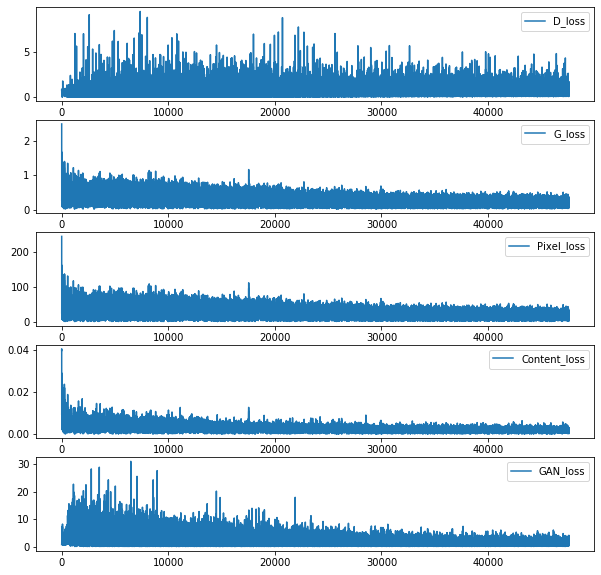

In [35]:
i = 0
fig,ax = plt.subplots(5,1,figsize=(10,10))
for k,v in loss.items():
    if not k[0] == '_':
        ax[i].plot(v.ravel(),label=k)
        ax[i].legend()
        i+=1

In [13]:
import torch 
import torch.nn as nn

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,10,2, stride = 2)
        self.relu = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc1 = nn.Linear(160,5)
        self.seq = nn.Sequential(nn.Linear(5,3), nn.Linear(3,2))
    
   
  
    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.fc1(self.flatten(x))
        x = self.seq(x)


net = myNet()
visualisation = {}

def hook_fn(m, i, o):
    visualisation[m] = o 

def get_all_layers(net):
    for name, layer in net._modules.items():
        #If it is a sequential, don't register a hook on it
        # but recursively register hook on all it's module children
        if isinstance(layer, nn.Sequential):
            get_all_layers(layer)
        else:
            # it's a non sequential. Register a hook
            layer.register_forward_hook(hook_fn)

get_all_layers(net)

  
out = net(torch.randn(1,3,8,8))

# Just to check whether we got all layers
visualisation.keys()      #output includes sequential layers

dict_keys([Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2)), ReLU(), Linear(in_features=160, out_features=5, bias=True), Linear(in_features=5, out_features=3, bias=True), Linear(in_features=3, out_features=2, bias=True)])

In [17]:
i,k = next(enumerate(visualisation))

In [24]:
j,l = k.named_parameters()

In [31]:
j[1].shape

torch.Size([10, 3, 2, 2])

In [16]:
visualisation['Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))']

KeyError: 'Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))'

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(j[1][])
